In [1]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✓ Google Drive montado")


Mounted at /content/drive
✓ Google Drive montado


In [2]:
import torch
import os

# Buscar el archivo en Drive
# Ajusta la ruta según dónde esté en tu Drive
DATASET_PATH = '/content/drive/MyDrive/kaspix_universal_rack.pt'

# Si está en otra ubicación, usa esto para buscarlo:
print("Buscando dataset...")
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    if 'kaspix_universal_rack.pt' in files:
        DATASET_PATH = os.path.join(root, 'kaspix_universal_rack.pt')
        print(f"✓ Dataset encontrado en: {DATASET_PATH}")
        break

# Cargar dataset
print("\nCargando dataset...")
data = torch.load(DATASET_PATH, weights_only=False)

print(f"✓ Dataset cargado exitosamente")
print(f"  Total muestras: {len(data['x']):,}")
print(f"  Claves: {list(data.keys())}")
print(f"  Tamaño en memoria: ~{DATASET_PATH}")


Buscando dataset...
✓ Dataset encontrado en: /content/drive/MyDrive/kaspix_universal_rack.pt

Cargando dataset...
✓ Dataset cargado exitosamente
  Total muestras: 99,371
  Claves: ['x', 'y', 'meta', 'max_knobs', 'description']
  Tamaño en memoria: ~/content/drive/MyDrive/kaspix_universal_rack.pt


In [3]:
# Verificar estructura rápida
from collections import Counter

print("📊 VERIFICACIÓN DEL DATASET\n")

# Topologías
topology_counts = Counter([s['topology_id'] for s in data['x']])
print(f"Topologías encontradas: {len(topology_counts)}")
for topo_id, count in sorted(topology_counts.items()):
    print(f"  Topology {topo_id}: {count:,} muestras ({count/len(data['x'])*100:.1f}%)")

# Verificar knobs
sample_0 = data['x'][0]
print(f"\nEjemplo muestra 0:")
print(f"  Audio shape: {sample_0['audio_in'].shape}")
print(f"  Knobs shape: {sample_0['knobs'].shape}")
print(f"  Topology ID: {sample_0['topology_id']}")
print(f"  Nombres knobs: {sample_0.get('original_names', 'No disponible')}")

print("\n✓ Dataset verificado - Listo para entrenar")


📊 VERIFICACIÓN DEL DATASET

Topologías encontradas: 4
  Topology 0: 20,000 muestras (20.1%)
  Topology 1: 20,000 muestras (20.1%)
  Topology 2: 29,371 muestras (29.6%)
  Topology 3: 30,000 muestras (30.2%)

Ejemplo muestra 0:
  Audio shape: (960,)
  Knobs shape: (5,)
  Topology ID: 0
  Nombres knobs: ['R_gain', 'C_cut', 'V_bias']

✓ Dataset verificado - Listo para entrenar


In [4]:
import numpy as np

print("🔧 ANÁLISIS DETALLADO DE KNOBS POR TOPOLOGÍA\n")

topology_knobs = {}

for sample in data['x']:
    topo_id = sample['topology_id']
    if topo_id not in topology_knobs:
        topology_knobs[topo_id] = {
            'knob_names': sample.get('original_names', []),
            'num_real_knobs': len(sample.get('original_names', [])),
            'example_values': sample['knobs'],
            'knobs_samples': []
        }
    topology_knobs[topo_id]['knobs_samples'].append(sample['knobs'])

print("="*60)
for topo_id in sorted(topology_knobs.keys()):
    info = topology_knobs[topo_id]
    knobs_array = np.array(info['knobs_samples'])

    print(f"\nTopology {topo_id}:")
    print(f"  Knobs reales: {info['num_real_knobs']}")
    print(f"  Nombres: {info['knob_names']}")
    print(f"  Ejemplo valores: {info['example_values']}")
    print(f"\n  Rangos por knob:")

    for i in range(5):
        kmin = knobs_array[:, i].min()
        kmax = knobs_array[:, i].max()
        kmean = knobs_array[:, i].mean()
        kstd = knobs_array[:, i].std()

        # Detectar si es padding (todos ceros o constante)
        is_padding = (kmax - kmin) < 1e-9
        status = "🔴 PADDING" if is_padding else "✅ ACTIVO"

        print(f"    Knob[{i}]: min={kmin:8.4f}, max={kmax:8.4f}, "
              f"mean={kmean:8.4f}, std={kstd:8.4f} {status}")

print("\n" + "="*60)

# VERIFICACIÓN CRÍTICA: Normalización global
print("\n📐 VERIFICACIÓN DE NORMALIZACIÓN GLOBAL")
all_knobs = np.stack([x['knobs'] for x in data['x']])
print(f"\nShape all_knobs: {all_knobs.shape}")

for i in range(5):
    kmin = all_knobs[:, i].min()
    kmax = all_knobs[:, i].max()
    kmean = all_knobs[:, i].mean()

    # Verificar si este knob es usado por alguna topología
    is_used = False
    for topo_info in topology_knobs.values():
        topo_knobs = np.array(topo_info['knobs_samples'])
        if (topo_knobs[:, i].max() - topo_knobs[:, i].min()) > 1e-9:
            is_used = True
            break

    status = "✅ USADO" if is_used else "⚠️ SIEMPRE PADDING"
    print(f"Knob[{i}] global: min={kmin:.4f}, max={kmax:.4f}, mean={kmean:.4f} {status}")

print("\n" + "="*60)
print("\n⚠️ IMPORTANTE PARA NORMALIZACIÓN:")
print("   Si algún knob es 'SIEMPRE PADDING', su normalización será (0-0)/(0-0+eps) = 0")
print("   Esto está bien, no afectará el entrenamiento.")
print("   Los knobs activos se normalizarán correctamente a [0,1]")


🔧 ANÁLISIS DETALLADO DE KNOBS POR TOPOLOGÍA


Topology 0:
  Knobs reales: 3
  Nombres: ['R_gain', 'C_cut', 'V_bias']
  Ejemplo valores: [6.4122812e+03 1.6033449e-07 8.5523367e-01 0.0000000e+00 0.0000000e+00]

  Rangos por knob:
    Knob[0]: min=2000.0996, max=17999.9805, mean=10020.6416, std=4581.0820 ✅ ACTIVO
    Knob[1]: min=  0.0000, max=  0.0000, mean=  0.0000, std=  0.0000 ✅ ACTIVO
    Knob[2]: min=  0.1001, max=  0.9000, mean=  0.5001, std=  0.2316 ✅ ACTIVO
    Knob[3]: min=  0.0000, max=  0.0000, mean=  0.0000, std=  0.0000 🔴 PADDING
    Knob[4]: min=  0.0000, max=  0.0000, mean=  0.0000, std=  0.0000 🔴 PADDING

Topology 1:
  Knobs reales: 3
  Nombres: ['R_gain', 'C_hp', 'R_load']
  Ejemplo valores: [6.4122812e+03 1.6033449e-07 1.7104673e+05 0.0000000e+00 0.0000000e+00]

  Rangos por knob:
    Knob[0]: min=2000.0996, max=17999.9805, mean=10020.6416, std=4581.0820 ✅ ACTIVO
    Knob[1]: min=  0.0000, max=  0.0000, mean=  0.0000, std=  0.0000 ✅ ACTIVO
    Knob[2]: min=20014.9141, m

In [5]:
# CELDA DE VERIFICACIÓN URGENTE
import numpy as np

print("🚨 VERIFICACIÓN CRÍTICA DE VALORES PEQUEÑOS\n")

# Verificar si realmente hay valores no-cero en Knob[1] y Knob[3]
all_knobs = np.stack([x['knobs'] for x in data['x']])

for knob_idx in [1, 3]:
    values = all_knobs[:, knob_idx]
    non_zero = values[values != 0]

    print(f"Knob[{knob_idx}]:")
    print(f"  Total muestras: {len(values)}")
    print(f"  Valores != 0: {len(non_zero)}")
    print(f"  Min (todos): {values.min():.15e}")
    print(f"  Max (todos): {values.max():.15e}")

    if len(non_zero) > 0:
        print(f"  Min (no-cero): {non_zero.min():.15e}")
        print(f"  Max (no-cero): {non_zero.max():.15e}")
        print(f"  Primeros 5 no-cero: {non_zero[:5]}")
    print()

# Verificar ejemplo específico que mostraste
print("Verificación muestra específica de Topology 1:")
for i, sample in enumerate(data['x']):
    if sample['topology_id'] == 1:
        print(f"  Muestra {i}: knobs = {sample['knobs']}")
        break


🚨 VERIFICACIÓN CRÍTICA DE VALORES PEQUEÑOS

Knob[1]:
  Total muestras: 99371
  Valores != 0: 99371
  Min (todos): 2.000274612612429e-08
  Max (todos): 1.799993185613857e-07
  Min (no-cero): 2.000274612612429e-08
  Max (no-cero): 1.799993185613857e-07
  Primeros 5 no-cero: [1.6033449e-07 1.5569748e-07 9.1176389e-08 3.9353704e-08 8.6900911e-08]

Knob[3]:
  Total muestras: 99371
  Valores != 0: 59371
  Min (todos): 0.000000000000000e+00
  Max (todos): 3.599865578962635e-07
  Min (no-cero): 2.000002830016001e-09
  Max (no-cero): 3.599865578962635e-07
  Primeros 5 no-cero: [1.5761959e-08 9.9822106e-09 1.6997653e-08 1.3350127e-08 1.6042351e-08]

Verificación muestra específica de Topology 1:
  Muestra 20000: knobs = [6.4122812e+03 1.6033449e-07 1.7104673e+05 0.0000000e+00 0.0000000e+00]


In [6]:
# ============================================================
# CONFIGURACIÓN ESTANDARIZADA DEL BENCHMARK
# ============================================================

BENCHMARK_CONFIG = {
    # Dataset (ya está cargado en 'data')
    'seed': 42,

    # Split (70/15/15)
    'train_ratio': 0.70,
    'val_ratio': 0.15,
    'test_ratio': 0.15,

    # Data loader
    'batch_size': 32,
    'num_workers': 2,
    'pin_memory': True,
    'drop_last': True,

    # Training
    'epochs': 50,
    'learning_rate': 1e-3,
    'weight_decay': 0,
    'gradient_clip': 1.0,

    # Scheduler
    'scheduler_patience': 5,
    'scheduler_factor': 0.5,

    # Model specs (fijos para todas las arquitecturas)
    'input_size': 10,  # 1 audio + 5 knobs + 4 topology
    'num_knobs': 5,
    'num_topologies': 4,
    'output_size': 1,

    # Noise en parámetros y QAT
    'analog_levels': 32,      # Equivalente a 5 bits (Resistencias estándar)
    'noise_std': 0.03,        # 3% de ruido (Tolerancia típica de componentes)

    # Loss
    'criterion': 'MSE',
}

print("✓ Configuración cargada")
print(f"  Seed: {BENCHMARK_CONFIG['seed']}")
print(f"  Split: {BENCHMARK_CONFIG['train_ratio']:.0%}/{BENCHMARK_CONFIG['val_ratio']:.0%}/{BENCHMARK_CONFIG['test_ratio']:.0%}")
print(f"  Batch size: {BENCHMARK_CONFIG['batch_size']}")
print(f"  Epochs: {BENCHMARK_CONFIG['epochs']}")
print(f"  Learning rate: {BENCHMARK_CONFIG['learning_rate']}")


✓ Configuración cargada
  Seed: 42
  Split: 70%/15%/15%
  Batch size: 32
  Epochs: 50
  Learning rate: 0.001


In [7]:
import torch
from torch.utils.data import Dataset
import numpy as np

class UniversalFilterDataset(Dataset):
    """
    Dataset estandarizado para benchmark.
    USAR ESTA MISMA CLASE EN TODAS LAS ARQUITECTURAS.
    """
    def __init__(self, datadict, kmin=None, kmax=None):
        self.xraw = datadict['x']
        self.yraw = datadict['y']
        self.fs = datadict.get('fs', 48000)

        # Specs fijos
        self.num_knobs = len(self.xraw[0]['knobs'])  # Debe ser 5
        self.knob_names = self.xraw[0].get('original_names',
                                           [f'knob{i}' for i in range(self.num_knobs)])
        self.num_topologies = 4

        # Normalización: usar params externos si se proveen
        if kmin is not None and kmax is not None:
            self.kmin = kmin
            self.kmax = kmax
        else:
            # Calcular de todo el dataset (solo para primera vez)
            all_knobs = np.stack([x['knobs'] for x in self.xraw])
            self.kmin = all_knobs.min(0)
            self.kmax = all_knobs.max(0)

        print(f"Dataset: {len(self)} muestras | Input: (T, {1+self.num_knobs+self.num_topologies})")
        print(f"  Normalización knobs:")
        print(f"    kmin: {self.kmin}")
        print(f"    kmax: {self.kmax}")

    def __len__(self):
        return len(self.xraw)

    def __getitem__(self, idx):
        xsample = self.xraw[idx]
        ysample = self.yraw[idx]

        T = len(xsample['audio_in'])

        # Audio
        audio = xsample['audio_in'].astype(np.float32).reshape(T, 1)

        # Knobs normalizados
        knobs_norm = (xsample['knobs'] - self.kmin) / (self.kmax - self.kmin + 1e-10)
        knobs_tiled = np.tile(knobs_norm[None, :], (T, 1))

        # Topology one-hot
        topo_id = int(xsample['topology_id'])
        topo_onehot = np.zeros(self.num_topologies)
        topo_onehot[topo_id] = 1
        topo_tiled = np.tile(topo_onehot[None, :], (T, 1))

        # Concatenar: [audio(1), knobs(5), topology(4)] = 10
        x = np.concatenate([audio, knobs_tiled, topo_tiled], axis=1)

        return torch.FloatTensor(x), torch.FloatTensor(ysample.reshape(T, 1))

print("✓ Dataset class definida")


✓ Dataset class definida


# ***BLOQUE DE RUIDO EN PARÁMETROS Y QUANTIZACIÓN***

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AnalogUtils:
    """
    Simula imperfecciones de hardware analógico:
    1. Cuantización (Niveles discretos de conductancia)
    2. Ruido de Peso (Variabilidad térmica/fabricación)
    3. Clipping (Límites de voltaje/conductancia)
    """

    @staticmethod
    def fake_quantize(weights, levels=16, range_limit=1.0):
        """
        Simula la baja resolución de las resistencias programables.
        levels: Cantidad de estados posibles de la resistencia (ej. 16, 32, 64).
        """
        # 1. Clamping: Restringir valores al rango físico [-range, range]
        w_clamped = torch.clamp(weights, -range_limit, range_limit)

        # 2. Escalar al rango de enteros [0, levels-1]
        scale = (levels - 1) / (2 * range_limit)
        w_scaled = (w_clamped + range_limit) * scale

        # 3. Redondear (Simular la discretización) - Usamos .detach() para el round
        # pero mantenemos el gradiente fluyendo (Straight Through Estimator)
        w_rounded = (w_scaled.round() - w_scaled).detach() + w_scaled

        # 4. Des-escalar de vuelta al rango original
        w_quant = (w_rounded / scale) - range_limit
        return w_quant

    @staticmethod
    def inject_noise(weights, std_dev=0.02):
        """
        Agrega ruido gaussiano a los pesos para simular deriva térmica y ruido de lectura.
        std_dev: 0.02 significa 2% de ruido respecto a la escala unitaria.
        """
        noise = torch.randn_like(weights) * std_dev
        return weights + noise

class AnalogLinear(nn.Linear):
    """
    Una capa Linear (Densa) que se comporta como un Crossbar Array analógico.
    Reemplaza nn.Linear con esto.
    """
    def __init__(self, in_features, out_features, bias=True,
                 analog_levels=32, noise_std=0.02):
        super(AnalogLinear, self).__init__(in_features, out_features, bias)
        self.analog_levels = analog_levels
        self.noise_std = noise_std
        self.training_mode = True # Flag para activar/desactivar efectos

    def forward(self, input):
        # 1. Copiamos los pesos originales
        w_simulated = self.weight

        # 2. Aplicamos Cuantización (Si estamos entrenando o validando en modo hardware)
        w_simulated = AnalogUtils.fake_quantize(w_simulated, levels=self.analog_levels)

        # 3. Aplicamos Ruido (Solo si training_mode es True)
        if self.training and self.noise_std > 0:
            w_simulated = AnalogUtils.inject_noise(w_simulated, std_dev=self.noise_std)

        # 4. Operación Lineal usando los pesos "sucios"
        # F.linear usa (input, weight, bias)
        return F.linear(input, w_simulated, self.bias)

class AnalogConv1d(nn.Conv1d):
    """
    Versión analógica de Conv1d.
    Simula que los filtros de convolución están almacenados en memristores/resistencias.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True,
                 padding_mode='zeros', device=None, dtype=None,
                 analog_levels=32, noise_std=0.02):

        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, dilation, groups, bias, padding_mode, device, dtype)

        self.analog_levels = analog_levels
        self.noise_std = noise_std

    def forward(self, input):
        # 1. Copiamos pesos
        w_simulated = self.weight

        # 2. Cuantización (Simular resolución finita)
        w_simulated = AnalogUtils.fake_quantize(w_simulated, levels=self.analog_levels)

        # 3. Inyección de Ruido (Solo en training)
        if self.training and self.noise_std > 0:
            w_simulated = AnalogUtils.inject_noise(w_simulated, std_dev=self.noise_std)

        # 4. Convolución usando F.conv1d con los pesos sucios
        return nn.functional.conv1d(input, w_simulated, self.bias, self.stride,
                                    self.padding, self.dilation, self.groups)

print("✓ Capa AnalogConv1d definida")

✓ Capa AnalogConv1d definida


# ***LSTM***

In [9]:
import torch.nn as nn

class UniversalLSTM(nn.Module):
    """LSTM baseline para benchmark"""
    def __init__(self, input_size=10, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden,
            layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        return self.fc(out)

print("✓ Modelo LSTM definido")

class AnalogLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1,
                 analog_levels=32, noise_std=0.02):
        super(AnalogLSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.noise_std = noise_std

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # AnalogLinear ya es seguro, no necesita cambios
        self.fc = AnalogLinear(hidden_size, output_size,
                               analog_levels=analog_levels,
                               noise_std=noise_std)

    def forward(self, x):
        # Inicializar estados ocultos
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # --- LÓGICA STATELESS (Sin tocar los pesos originales) ---
        if self.training and self.noise_std > 0:
            # 1. Creamos copias temporales ruidosas (Out-of-place)
            noisy_params = {}
            for name, param in self.lstm.named_parameters():
                noise = torch.randn_like(param) * self.noise_std
                noisy_params[name] = param + noise

            # 2. Ejecutamos la LSTM usando los pesos ruidosos explícitos
            # Esto calcula el output y permite que el gradiente fluya a través del ruido
            # sin corromper el parámetro original 'param'.
            out, _ = stateless.functional_call(self.lstm, noisy_params, (x, (h0, c0)))
        else:
            # Ejecución limpia (Validación / Test sin ruido térmico)
            out, _ = self.lstm(x, (h0, c0))

        # --- SALIDA MANY-TO-MANY ---
        # Ya NO hacemos out[:, -1, :]. Pasamos la secuencia completa (batch, 960, hidden)
        out = self.fc(out)

        return out


print("✓ Modelo LSTM analógico definido")





✓ Modelo LSTM definido
✓ Modelo LSTM analógico definido


In [10]:
import torch.nn.utils.stateless as stateless

In [11]:
def compute_metrics(model, loader, device):
    """Métricas estandarizadas para benchmark"""
    model.eval()
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            y_true_all.append(y.cpu().numpy())
            y_pred_all.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    # Métricas
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    # R²
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)

    return {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2)
    }

print("✅ Funciones de entrenamiento definidas")

✅ Funciones de entrenamiento definidas


In [12]:
import torch.optim as optim

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(),
                                       BENCHMARK_CONFIG['gradient_clip'])
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def val_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_loss += criterion(pred, y).item()

    return total_loss / len(loader)

def compute_metrics(model, loader, device):
    """Métricas estandarizadas para benchmark"""
    model.eval()
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            y_true_all.append(y.cpu().numpy())
            y_pred_all.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    # Métricas
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    # R²
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)

    return {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2)
    }

print("✓ Funciones de entrenamiento definidas")


✓ Funciones de entrenamiento definidas


In [13]:
from torch.utils.data import DataLoader, random_split

# Reproducibilidad
torch.manual_seed(BENCHMARK_CONFIG['seed'])
np.random.seed(BENCHMARK_CONFIG['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Crear dataset (data ya está cargado)
print("1️⃣ Creando dataset...")
dataset = UniversalFilterDataset(data)

# Split con seed fijo
print(f"\n2️⃣ Creando split (seed={BENCHMARK_CONFIG['seed']})...")
total = len(dataset)
train_size = int(BENCHMARK_CONFIG['train_ratio'] * total)
val_size = int(BENCHMARK_CONFIG['val_ratio'] * total)
test_size = total - train_size - val_size

trainds, valds, testds = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(BENCHMARK_CONFIG['seed'])
)

print(f"   Train: {len(trainds):,} | Val: {len(valds):,} | Test: {len(testds):,}")

# IMPORTANTE: Guardar indices del split para reproducibilidad
split_indices = {
    'train': trainds.indices,
    'val': valds.indices,
    'test': testds.indices
}
torch.save(split_indices, 'benchmark_split_indices.pt')
print(f"   ✓ Índices guardados en: benchmark_split_indices.pt")

# Data loaders
print(f"\n3️⃣ Creando data loaders...")
train_loader = DataLoader(
    trainds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=True,
    num_workers=BENCHMARK_CONFIG['num_workers'],
    pin_memory=BENCHMARK_CONFIG['pin_memory'],
    drop_last=BENCHMARK_CONFIG['drop_last']
)

val_loader = DataLoader(
    valds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=False,
    num_workers=BENCHMARK_CONFIG['num_workers']
)

test_loader = DataLoader(
    testds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=False,
    num_workers=BENCHMARK_CONFIG['num_workers']
)

print(f"   Batches - Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")


Device: cpu

1️⃣ Creando dataset...
Dataset: 99371 muestras | Input: (T, 10)
  Normalización knobs:
    kmin: [2.00000793e+03 2.00027461e-08 1.00074574e-01 0.00000000e+00
 0.00000000e+00]
    kmax: [1.7999992e+04 1.7999932e-07 1.7999923e+05 3.5998656e-07 1.7999825e+05]

2️⃣ Creando split (seed=42)...
   Train: 69,559 | Val: 14,905 | Test: 14,907
   ✓ Índices guardados en: benchmark_split_indices.pt

3️⃣ Creando data loaders...
   Batches - Train: 2173 | Val: 466 | Test: 466


In [ ]:
import time
import torch.optim as optim

# -------------------- Modelo analógico LSTM --------------------
print(f"\n4️⃣ Inicializando modelo LSTM ANALÓGICO (Hardware-Aware)...")

# Instanciamos la clase AnalogLSTMModel
model = AnalogLSTMModel(
    input_size=BENCHMARK_CONFIG['input_size'],
    hidden_size=128,          # Equivalente a 'hidden' en UniversalLSTM
    output_size=1,            # Salida de 1 canal
    num_layers=2,             # 2 capas recurrentes
    # Parámetros físicos para hardware analógico:
    analog_levels=BENCHMARK_CONFIG['analog_levels'],
    noise_std=BENCHMARK_CONFIG['noise_std']
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Parámetros: {num_params:,}")
print(f"   Configuración Física: {BENCHMARK_CONFIG['analog_levels']} niveles, Ruido {BENCHMARK_CONFIG['noise_std']}")
# ----------------------------------------------------------------

# Loss & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=BENCHMARK_CONFIG['learning_rate']
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=BENCHMARK_CONFIG['scheduler_patience'],
    factor=BENCHMARK_CONFIG['scheduler_factor']
)

# Training loop
print(f"\n5️⃣ Entrenando (epochs={BENCHMARK_CONFIG['epochs']})...\n")

best_val_loss = float('inf')
best_epoch = 0  # Inicializar esta variable
train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(1, BENCHMARK_CONFIG['epochs'] + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = val_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch:2d} | Train: {train_loss:.6f} | Val: {val_loss:.6f}")

    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': BENCHMARK_CONFIG,
            'normalization': {
                'kmin': dataset.kmin.tolist(),
                'kmax': dataset.kmax.tolist()
            }
        }
        torch.save(checkpoint, 'lstm_best.pt')
        print(f"   💾 BEST SAVED (val_loss={val_loss:.6f})")

elapsed = time.time() - start_time
print(f"\n✓ Entrenamiento completado en {elapsed/60:.1f} minutos")
print(f"✓ Mejor época: {best_epoch} con val_loss={best_val_loss:.6f}")



4️⃣ Inicializando modelo LSTM ANALÓGICO (Hardware-Aware)...
   Parámetros: 203,905
   Configuración Física: 32 niveles, Ruido 0.03

5️⃣ Entrenando (epochs=50)...



/tmp/ipython-input-3221335131.py:55: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  out, _ = stateless.functional_call(self.lstm, noisy_params, (x, (h0, c0)))


Epoch  1 | Train: 0.014735 | Val: 0.006416
   💾 BEST SAVED (val_loss=0.006416)
Epoch  2 | Train: 0.005522 | Val: 0.002643
   💾 BEST SAVED (val_loss=0.002643)
Epoch  3 | Train: 0.002948 | Val: 0.001934
   💾 BEST SAVED (val_loss=0.001934)
Epoch  4 | Train: 0.002320 | Val: 0.001636
   💾 BEST SAVED (val_loss=0.001636)
Epoch  5 | Train: 0.001906 | Val: 0.001334
   💾 BEST SAVED (val_loss=0.001334)
Epoch  6 | Train: 0.001617 | Val: 0.001147
   💾 BEST SAVED (val_loss=0.001147)
Epoch  7 | Train: 0.001354 | Val: 0.000931
   💾 BEST SAVED (val_loss=0.000931)
Epoch  8 | Train: 0.001126 | Val: 0.000832
   💾 BEST SAVED (val_loss=0.000832)
Epoch  9 | Train: 0.000968 | Val: 0.000617
   💾 BEST SAVED (val_loss=0.000617)
Epoch 10 | Train: 0.000849 | Val: 0.000538
   💾 BEST SAVED (val_loss=0.000538)
Epoch 11 | Train: 0.000780 | Val: 0.000594
Epoch 12 | Train: 0.000678 | Val: 0.000463
   💾 BEST SAVED (val_loss=0.000463)
Epoch 13 | Train: 0.000587 | Val: 0.000483
Epoch 14 | Train: 0.000491 | Val: 0.000196
  

In [ ]:
# Evaluación final en test set
print(f"\n6️⃣ Evaluación final en test set...")
model.load_state_dict(torch.load('lstm_anal_final.pt')['model_state_dict'])
test_metrics = compute_metrics(model, test_loader, device)

print(f"\n{'='*50}")
print(f"RESULTADOS LSTM BASELINE")
print(f"{'='*50}")
print(f"Best epoch: {best_epoch}")
print(f"Training time: {elapsed/60:.1f} min")
print(f"Parámetros: {num_params:,}")
print(f"\nTest Metrics:")
print(f"  MSE:  {test_metrics['mse']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"  MAE:  {test_metrics['mae']:.6f}")
print(f"  R²:   {test_metrics['r2']:.6f}")
print(f"{'='*50}")

# Guardar resultados para benchmark
results = {
    'model_name': 'LSTM',
    'architecture': 'LSTM(128, layers=2)',
    'params': num_params,
    'train_time_min': elapsed/60,
    'best_epoch': best_epoch,
    'best_val_loss': best_val_loss,
    'test_metrics': test_metrics,
    'config': BENCHMARK_CONFIG,
    'train_losses': train_losses,
    'val_losses': val_losses
}

torch.save(results, 'lstm_benchmark_results.pt')
print(f"\n✓ Resultados guardados: lstm_benchmark_results.pt")



6️⃣ Evaluación final en test set...

RESULTADOS LSTM BASELINE
Best epoch: 48
Training time: 49.1 min
Parámetros: 203,905

Test Metrics:
  MSE:  0.000029
  RMSE: 0.005390
  MAE:  0.002864
  R²:   0.999394

✓ Resultados guardados: lstm_benchmark_results.pt


NameError: name 'train_losses' is not defined

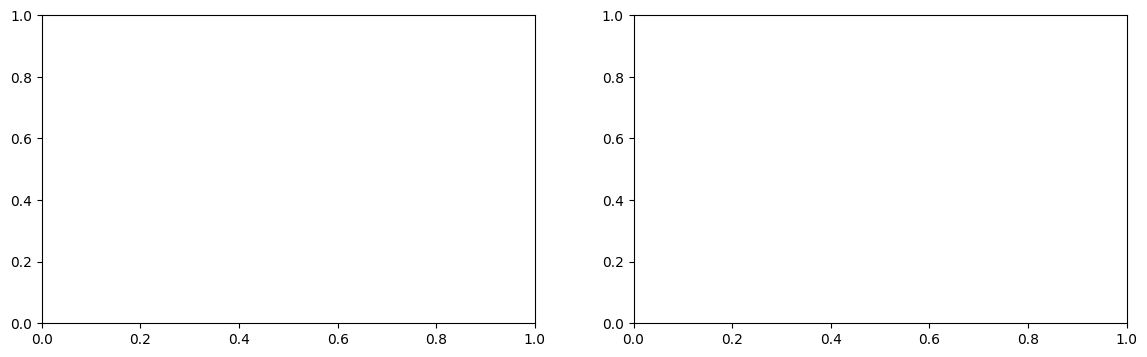

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss curves
axes[0].plot(train_losses, label='Train', linewidth=2)
axes[0].plot(val_losses, label='Val', linewidth=2)
axes[0].axvline(best_epoch-1, color='g', linestyle='--', label=f'Best (epoch {best_epoch})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training History')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_yscale('log')

# Val/Train ratio
ratio = np.array(val_losses) / np.array(train_losses)
axes[1].plot(ratio, color='purple', linewidth=2)
axes[1].axhline(1, color='r', linestyle='--', label='No overfitting')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Val/Train Ratio')
axes[1].set_title('Overfitting Check')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_curves.png', dpi=150)
plt.show()

print("✓ Gráficas guardadas en: lstm_training_curves.png")


In [ ]:
# Descargar archivos importantes
from google.colab import files

print("Descargando archivos del benchmark...")

files.download('lstm_best.pt')
files.download('lstm_benchmark_results.pt')
files.download('benchmark_split_indices.pt')
files.download('lstm_training_curves.png')

print("\n✓ Descarga completa!")
print("\nArchivos descargados:")
print("  1. lstm_best.pt - Mejor modelo entrenado")
print("  2. lstm_benchmark_results.pt - Resultados y métricas")
print("  3. benchmark_split_indices.pt - Índices del split (CRUCIAL)")
print("  4. lstm_training_curves.png - Gráficas de entrenamiento")


In [ ]:
# Ejecuta esta celda y pégame el resultado:
results = torch.load('lstm_benchmark_results.pt')

print("="*50)
print("RESULTADOS FINALES LSTM")
print("="*50)
print(f"Modelo: {results['model_name']}")
print(f"Arquitectura: {results['architecture']}")
print(f"Parámetros: {results['params']:,}")
print(f"Tiempo entrenamiento: {results['train_time_min']:.1f} min")
print(f"Best epoch: {results['best_epoch']}")
print(f"Best val loss: {results['best_val_loss']:.6f}")
print(f"\nMétricas en TEST:")
print(f"  MSE:  {results['test_metrics']['mse']:.6f}")
print(f"  RMSE: {results['test_metrics']['rmse']:.6f}")
print(f"  MAE:  {results['test_metrics']['mae']:.6f}")
print(f"  R²:   {results['test_metrics']['r2']:.6f}")
print("="*50)


# ***TCN***

In [17]:
import torch
import torch.nn as nn

# ============================================================
# TCN ADAPTADA PARA BENCHMARK (compatible con LSTM input)
# ============================================================

class FiLM(nn.Module):
    """Feature-wise Linear Modulation para control con knobs"""
    def __init__(self, channels, knob_dim):
        super().__init__()
        # Genera gamma (escala) y beta (desplazamiento) para cada canal
        self.gen = nn.Linear(knob_dim, channels * 2)

    def forward(self, x, knobs):
        # knobs: (batch, knob_dim)
        # x: (batch, channels, seq_len)
        params = self.gen(knobs).unsqueeze(2)  # (batch, channels*2, 1)
        gamma, beta = torch.chunk(params, 2, dim=1)
        return x * gamma + beta

class TemporalBlock(nn.Module):
    """Bloque TCN con dilated convolution + FiLM + residual"""
    def __init__(self, in_ch, out_ch, kernel_size, dilation, knob_dim):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation

        # Convolution con dilatación
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size,
                             padding=self.padding, dilation=dilation)

        # FiLM layer para modular con knobs
        self.film = FiLM(out_ch, knob_dim)

        # Activación y normalización
        self.act = nn.PReLU()
        self.norm = nn.GroupNorm(1, out_ch)

        # Residual connection
        self.res = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, knobs):
        res = self.res(x)

        # Convolution con causal padding
        x = self.conv(x)
        if self.padding > 0:
            x = x[:, :, :-self.padding]  # Remover padding futuro

        # Modular con knobs via FiLM
        x = self.film(x, knobs)

        # Normalizar y aplicar activación
        x = self.norm(x)
        return self.act(x + res)

class UniversalTCN(nn.Module):
    """TCN para benchmark - Compatible con mismo input que LSTM"""
    def __init__(self, input_size=10, channels=128, num_layers=12, kernel_size=3):
        super().__init__()

        self.channels = channels
        self.num_layers = num_layers

        # Separar input en audio (1) y control (9 = 5 knobs + 4 topology)
        self.num_control = input_size - 1  # 9 señales de control

        # TCN layers con dilatación exponencial
        self.layers = nn.ModuleList()

        # Primera capa: 1 canal audio → channels
        self.layers.append(
            TemporalBlock(1, channels, kernel_size, dilation=1, knob_dim=self.num_control)
        )

        # Capas restantes con dilatación creciente
        for i in range(1, num_layers):
            dilation = 2 ** i
            self.layers.append(
                TemporalBlock(channels, channels, kernel_size, dilation, knob_dim=self.num_control)
            )

        # Output layer
        self.output = nn.Conv1d(channels, 1, kernel_size=1, bias=False)

    def forward(self, x):
        # x: (batch, seq_len, 10)
        # Separar audio y control
        audio = x[:, :, 0:1]  # (batch, seq_len, 1)
        control = x[:, :, 1:]  # (batch, seq_len, 9)

        # TCN espera (batch, channels, seq_len)
        audio = audio.permute(0, 2, 1)  # (batch, 1, seq_len)

        # Control toma el primer timestep (es constante en toda la secuencia)
        knobs = control[:, 0, :]  # (batch, 9)

        # Procesar con TCN
        out = audio
        for layer in self.layers:
            out = layer(out, knobs)

        # Output layer
        out = self.output(out)  # (batch, 1, seq_len)

        # Volver a formato (batch, seq_len, 1)
        out = out.permute(0, 2, 1)

        return out

print("✓ Modelo TCN definido (compatible con benchmark)")

# --- Bloques Auxiliares Analógicos para TCN ---

class AnalogFiLM(nn.Module):
    def __init__(self, channels, knob_dim, analog_levels=32, noise_std=0.02):
        super().__init__()
        # Usamos AnalogLinear para generar los coeficientes
        self.gen = AnalogLinear(knob_dim, channels * 2,
                                analog_levels=analog_levels, noise_std=noise_std)

    def forward(self, x, knobs):
        params = self.gen(knobs).unsqueeze(2)
        gamma, beta = torch.chunk(params, 2, dim=1)
        return x * gamma + beta

class AnalogTemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, knob_dim,
                 analog_levels=32, noise_std=0.02):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation

        # CONVOLUCIÓN ANALÓGICA
        self.conv = AnalogConv1d(in_ch, out_ch, kernel_size,
                                 padding=self.padding, dilation=dilation,
                                 analog_levels=analog_levels, noise_std=noise_std)

        # FiLM ANALÓGICO
        self.film = AnalogFiLM(out_ch, knob_dim,
                               analog_levels=analog_levels, noise_std=noise_std)

        self.act = nn.PReLU()
        self.norm = nn.GroupNorm(1, out_ch)

        # RESIDUAL ANALÓGICA (Si es necesaria proyección 1x1)
        if in_ch != out_ch:
            self.res = AnalogConv1d(in_ch, out_ch, 1,
                                    analog_levels=analog_levels, noise_std=noise_std)
        else:
            self.res = nn.Identity()

    def forward(self, x, knobs):
        res = self.res(x)
        x = self.conv(x)
        if self.padding > 0:
            x = x[:, :, :-self.padding]

        x = self.film(x, knobs)
        x = self.norm(x)
        return self.act(x + res)

# --- Modelo Principal TCN Analógico ---

class AnalogTCNModel(nn.Module):
    def __init__(self, input_size=10, channels=128, num_layers=12, kernel_size=3,
                 analog_levels=32, noise_std=0.02):
        super().__init__()

        self.channels = channels
        self.num_layers = num_layers
        self.num_control = input_size - 1

        self.layers = nn.ModuleList()

        # Primera capa (Input -> Channels)
        self.layers.append(
            AnalogTemporalBlock(1, channels, kernel_size, dilation=1,
                                knob_dim=self.num_control,
                                analog_levels=analog_levels, noise_std=noise_std)
        )

        # Capas profundas
        for i in range(1, num_layers):
            dilation = 2 ** i
            self.layers.append(
                AnalogTemporalBlock(channels, channels, kernel_size, dilation,
                                    knob_dim=self.num_control,
                                    analog_levels=analog_levels, noise_std=noise_std)
            )

        # Output Layer (1x1 Conv Analógica)
        self.output = AnalogConv1d(channels, 1, kernel_size=1, bias=False,
                                   analog_levels=analog_levels, noise_std=noise_std)

    def forward(self, x):
        audio = x[:, :, 0:1]
        control = x[:, :, 1:]

        audio = audio.permute(0, 2, 1) # (B, 1, T)
        knobs = control[:, 0, :]       # (B, 9)

        out = audio
        for layer in self.layers:
            out = layer(out, knobs)

        out = self.output(out)
        out = out.permute(0, 2, 1) # (B, T, 1)

        return out

print("✓ Modelo AnalogTCN definido")


✓ Modelo TCN definido (compatible con benchmark)
✓ Modelo AnalogTCN definido


In [18]:
from torch.utils.data import DataLoader, Subset
import numpy as np

# Reproducibilidad
torch.manual_seed(BENCHMARK_CONFIG['seed'])
np.random.seed(BENCHMARK_CONFIG['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Crear dataset (data ya está cargado)
print("1️⃣ Creando dataset...")
dataset = UniversalFilterDataset(data)

# ============================================================
# CARGAR MISMO SPLIT QUE LSTM (CRÍTICO PARA BENCHMARK)
# ============================================================
print(f"\n2️⃣ Cargando MISMO split que LSTM...")

# Cargar índices del entrenamiento LSTM
split_indices = torch.load('benchmark_split_indices.pt')

print(f"   ⚠️ IMPORTANTE: Usando EXACTAMENTE los mismos datos que LSTM")
print(f"   Train indices: {len(split_indices['train'])} muestras")
print(f"   Val indices: {len(split_indices['val'])} muestras")
print(f"   Test indices: {len(split_indices['test'])} muestras")

# Crear subsets con los MISMOS índices
trainds = Subset(dataset, split_indices['train'])
valds = Subset(dataset, split_indices['val'])
testds = Subset(dataset, split_indices['test'])

print(f"   Train: {len(trainds):,} | Val: {len(valds):,} | Test: {len(testds):,}")
print(f"   ✅ Split idéntico al LSTM verificado")

# Data loaders (MISMO batch size, etc.)
print(f"\n3️⃣ Creando data loaders...")
train_loader = DataLoader(
    trainds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=True,  # Shuffle está bien, los índices ya definen el split
    num_workers=BENCHMARK_CONFIG['num_workers'],
    pin_memory=BENCHMARK_CONFIG['pin_memory'],
    drop_last=BENCHMARK_CONFIG['drop_last']
)

val_loader = DataLoader(
    valds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=False,
    num_workers=BENCHMARK_CONFIG['num_workers']
)

test_loader = DataLoader(
    testds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=False,
    num_workers=BENCHMARK_CONFIG['num_workers']
)

print(f"   Batches - Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")
print(f"   ✅ Data loaders listos con configuración idéntica a LSTM")


Device: cpu

1️⃣ Creando dataset...
Dataset: 99371 muestras | Input: (T, 10)
  Normalización knobs:
    kmin: [2.00000793e+03 2.00027461e-08 1.00074574e-01 0.00000000e+00
 0.00000000e+00]
    kmax: [1.7999992e+04 1.7999932e-07 1.7999923e+05 3.5998656e-07 1.7999825e+05]

2️⃣ Cargando MISMO split que LSTM...
   ⚠️ IMPORTANTE: Usando EXACTAMENTE los mismos datos que LSTM
   Train indices: 69559 muestras
   Val indices: 14905 muestras
   Test indices: 14907 muestras
   Train: 69,559 | Val: 14,905 | Test: 14,907
   ✅ Split idéntico al LSTM verificado

3️⃣ Creando data loaders...
   Batches - Train: 2173 | Val: 466 | Test: 466
   ✅ Data loaders listos con configuración idéntica a LSTM


In [ ]:
import time

# # Modelo TCN
# print(f"\n4️⃣ Inicializando modelo TCN...")
# model = UniversalTCN(
#     input_size=BENCHMARK_CONFIG['input_size'],
#     channels=128,
#     num_layers=12,
#     kernel_size=3
# ).to(device)

# num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"   Parámetros: {num_params:,}")

# -------------------- Modelo analogico --------------------
# Modelo TCN Analógico
print(f"\n4️⃣ Inicializando modelo TCN (Hardware-Aware)...")

model = AnalogTCNModel(
    input_size=BENCHMARK_CONFIG['input_size'],
    channels=128,       # Mismos canales que tu benchmark original
    num_layers=12,      # Mismas capas
    kernel_size=3,      # Mismo kernel
    # --- Parámetros Físicos ---
    analog_levels=BENCHMARK_CONFIG['analog_levels'],
    noise_std=BENCHMARK_CONFIG['noise_std']
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Parámetros: {num_params:,}")
print(f"   Modo Físico: {BENCHMARK_CONFIG['analog_levels']} niveles | Ruido {BENCHMARK_CONFIG['noise_std']}")
# -------------------- Modelo analogico --------------------


# Loss & Optimizer (MISMO que LSTM)
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=BENCHMARK_CONFIG['learning_rate']
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=BENCHMARK_CONFIG['scheduler_patience']
)

# Training loop
print(f"\n5️⃣ Entrenando TCN (epochs={BENCHMARK_CONFIG['epochs']})...\n")

best_val_loss = float('inf')
train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(1, BENCHMARK_CONFIG['epochs'] + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = val_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch:2d} | Train: {train_loss:.6f} | Val: {val_loss:.6f}")

    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': BENCHMARK_CONFIG,
            'normalization': {
                'kmin': dataset.kmin.tolist(),
                'kmax': dataset.kmax.tolist()
            },
            'split_indices': split_indices  # Guardar para verificación
        }
        torch.save(checkpoint, 'tcn_best.pt')
        print(f"   💾 BEST SAVED (val_loss={val_loss:.6f})")

elapsed = time.time() - start_time
print(f"\n✓ Entrenamiento completado en {elapsed/60:.1f} minutos")



4️⃣ Inicializando modelo TCN (Hardware-Aware)...
   Parámetros: 576,780
   Modo Físico: 32 niveles | Ruido 0.03

5️⃣ Entrenando TCN (epochs=50)...

Epoch  1 | Train: 0.337817 | Val: 0.004984
   💾 BEST SAVED (val_loss=0.004984)
Epoch  2 | Train: 0.005540 | Val: 0.003194
   💾 BEST SAVED (val_loss=0.003194)
Epoch  3 | Train: 0.004000 | Val: 0.002718
   💾 BEST SAVED (val_loss=0.002718)
Epoch  4 | Train: 0.003327 | Val: 0.003009
Epoch  5 | Train: 0.002784 | Val: 0.002265
   💾 BEST SAVED (val_loss=0.002265)
Epoch  6 | Train: 0.002414 | Val: 0.001659
   💾 BEST SAVED (val_loss=0.001659)
Epoch  7 | Train: 0.002094 | Val: 0.001683
Epoch  8 | Train: 0.001870 | Val: 0.001326
   💾 BEST SAVED (val_loss=0.001326)
Epoch  9 | Train: 0.001687 | Val: 0.001299
   💾 BEST SAVED (val_loss=0.001299)
Epoch 10 | Train: 0.001543 | Val: 0.001230
   💾 BEST SAVED (val_loss=0.001230)
Epoch 11 | Train: 0.001380 | Val: 0.001205
   💾 BEST SAVED (val_loss=0.001205)
Epoch 12 | Train: 0.001293 | Val: 0.000906
   💾 BEST S

# ***RNN***

In [19]:
import torch.nn as nn

# ============================================================
# RNN ADAPTADA PARA BENCHMARK (compatible con LSTM/TCN input)
# ============================================================

class UniversalRNN(nn.Module):
    """
    RNN con Context MLP para benchmark.
    Compatible con mismo input que LSTM/TCN.
    """
    def __init__(self, input_size=10, hidden_size=256, num_layers=3):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Context dimension: 9 (5 knobs + 4 topology)
        self.context_dim = input_size - 1  # 10 - 1 = 9

        # A. Context MLP (Cerebro Lógico)
        # Procesa knobs + topology antes de la RNN
        self.context_mlp = nn.Sequential(
            nn.Linear(self.context_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Tanh()
        )

        # B. RNN Vanilla (Cerebro Temporal)
        # Input: audio(1) + context_embedding(32) = 33
        self.rnn = nn.RNN(
            input_size=1 + 32,  # Audio + contexto procesado
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=0.2 if num_layers > 1 else 0
        )

        # C. Output Head
        self.head = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.GELU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, 10)

        # Separar audio y contexto
        audio = x[:, :, 0:1]          # (batch, seq_len, 1)
        raw_context = x[:, 0, 1:]     # (batch, 9) - tomar tiempo 0 (es constante)

        # Procesar contexto con MLP
        ctx_emb = self.context_mlp(raw_context)  # (batch, 32)

        # Expandir contexto para toda la secuencia
        seq_len = audio.size(1)
        ctx_emb_expanded = ctx_emb.unsqueeze(1).repeat(1, seq_len, 1)  # (batch, seq_len, 32)

        # Concatenar audio + contexto procesado
        rnn_input = torch.cat([audio, ctx_emb_expanded], dim=2)  # (batch, seq_len, 33)

        # RNN forward
        rnn_out, _ = self.rnn(rnn_input)  # (batch, seq_len, hidden_size)

        # Output head
        output = self.head(rnn_out)  # (batch, seq_len, 1)

        return output

print("✅ Modelo RNN definido (compatible con benchmark)")

class AnalogRNNModel(nn.Module):
    def __init__(self, input_size=10, hidden_size=256, num_layers=3,
                 analog_levels=32, noise_std=0.02):
        super(AnalogRNNModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.context_dim = input_size - 1
        self.noise_std = noise_std

        # AnalogLinear es seguro
        self.context_mlp = nn.Sequential(
            AnalogLinear(self.context_dim, 64, analog_levels=analog_levels, noise_std=noise_std),
            nn.ReLU(),
            AnalogLinear(64, 32, analog_levels=analog_levels, noise_std=noise_std),
            nn.Tanh()
        )

        self.rnn = nn.RNN(
            input_size=1 + 32,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=0.2 if num_layers > 1 else 0
        )

        self.head = nn.Sequential(
            AnalogLinear(hidden_size, 128, analog_levels=analog_levels, noise_std=noise_std),
            nn.GELU(),
            AnalogLinear(128, 1, analog_levels=analog_levels, noise_std=noise_std)
        )

    def forward(self, x):
        # 1. Procesar contexto (AnalogLinear maneja su propio ruido)
        audio = x[:, :, 0:1]
        raw_context = x[:, 0, 1:]
        ctx_emb = self.context_mlp(raw_context)
        seq_len = audio.size(1)
        ctx_emb_expanded = ctx_emb.unsqueeze(1).repeat(1, seq_len, 1)
        rnn_input = torch.cat([audio, ctx_emb_expanded], dim=2)

        # 2. Ejecutar RNN (Con inyecciÃ³n segura Stateless)
        if self.training and self.noise_std > 0:
            noisy_params = {}
            for name, param in self.rnn.named_parameters():
                noisy_params[name] = param + torch.randn_like(param) * self.noise_std

            rnn_out, _ = stateless.functional_call(self.rnn, noisy_params, rnn_input)
        else:
            rnn_out, _ = self.rnn(rnn_input)

        # 3. Output
        output = self.head(rnn_out)

        return output
print("✓ Modelo AnalogRNN definido")

✅ Modelo RNN definido (compatible con benchmark)
✓ Modelo AnalogRNN definido


In [19]:
import torch.optim as optim
import numpy as np

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(
            model.parameters(),
            BENCHMARK_CONFIG['gradient_clip']
        )
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def val_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_loss += criterion(pred, y).item()

    return total_loss / len(loader)

def compute_metrics(model, loader, device):
    """Métricas estandarizadas para benchmark"""
    model.eval()
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            y_true_all.append(y.cpu().numpy())
            y_pred_all.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    # Métricas
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    # R²
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)

    return {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2)
    }

print("✅ Funciones de entrenamiento definidas")


✅ Funciones de entrenamiento definidas


In [20]:
from torch.utils.data import DataLoader, Subset
import numpy as np
import os

# Reproducibilidad
torch.manual_seed(BENCHMARK_CONFIG['seed'])
np.random.seed(BENCHMARK_CONFIG['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 1️⃣ Crear dataset
print(f"\n1️⃣ Creando dataset...")
dataset = UniversalFilterDataset(data)

# 2️⃣ CARGAR MISMO SPLIT (desde Drive)
print(f"\n2️⃣ Cargando split desde Drive...")
SPLIT_PATH = 'benchmark_split_indices.pt'

if not os.path.exists(SPLIT_PATH):
    print("❌ ERROR: benchmark_split_indices.pt no encontrado en Drive")
    print("   Debes subirlo primero!")
    raise FileNotFoundError(f"No se encuentra: {SPLIT_PATH}")
else:
    split_indices = torch.load(SPLIT_PATH)
    print(f"✅ Split cargado desde Drive (mentira lo subí a collab)")
    print(f"   Train indices: {len(split_indices['train']):,} muestras")
    print(f"   Val indices: {len(split_indices['val']):,} muestras")
    print(f"   Test indices: {len(split_indices['test']):,} muestras")

    # Crear subsets con los MISMOS índices que LSTM/TCN
    trainds = Subset(dataset, split_indices['train'])
    valds = Subset(dataset, split_indices['val'])
    testds = Subset(dataset, split_indices['test'])

    print(f"   Train: {len(trainds):,} | Val: {len(valds):,} | Test: {len(testds):,}")
    print(f"   ✓ Split idéntico al LSTM/TCN")

# 3️⃣ Data loaders
print(f"\n3️⃣ Creando data loaders...")
train_loader = DataLoader(
    trainds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=True,
    num_workers=BENCHMARK_CONFIG['num_workers'],
    pin_memory=BENCHMARK_CONFIG['pin_memory'],
    drop_last=BENCHMARK_CONFIG['drop_last']
)

val_loader = DataLoader(
    valds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=False,
    num_workers=BENCHMARK_CONFIG['num_workers']
)

test_loader = DataLoader(
    testds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=False,
    num_workers=BENCHMARK_CONFIG['num_workers']
)

print(f"   Batches - Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")
print(f"\n✅ Data preparada con configuración idéntica a LSTM/TCN")


Device: cuda

1️⃣ Creando dataset...
Dataset: 99371 muestras | Input: (T, 10)
  Normalización knobs:
    kmin: [2.00000793e+03 2.00027461e-08 1.00074574e-01 0.00000000e+00
 0.00000000e+00]
    kmax: [1.7999992e+04 1.7999932e-07 1.7999923e+05 3.5998656e-07 1.7999825e+05]

2️⃣ Cargando split desde Drive...
✅ Split cargado desde Drive (mentira lo subí a collab)
   Train indices: 69,559 muestras
   Val indices: 14,905 muestras
   Test indices: 14,907 muestras
   Train: 69,559 | Val: 14,905 | Test: 14,907
   ✓ Split idéntico al LSTM/TCN

3️⃣ Creando data loaders...
   Batches - Train: 2173 | Val: 466 | Test: 466

✅ Data preparada con configuración idéntica a LSTM/TCN


In [21]:
import time

# Modelo RNN
print(f"\n4️⃣ Inicializando modelo RNN...")
model = UniversalRNN(
    input_size=BENCHMARK_CONFIG['input_size'],
    hidden_size=256,
    num_layers=3
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Parámetros: {num_params:,}")

# ------------------------- Modelo Analogico ----------------------------
print(f"\n4️⃣ Inicializando modelo RNN (Hardware-Aware)...")

model = AnalogRNNModel(
    input_size=BENCHMARK_CONFIG['input_size'],
    hidden_size=256,    # Mismo hidden size que tu benchmark original
    num_layers=3,       # Mismas capas
    # --- Parámetros Físicos ---
    analog_levels=BENCHMARK_CONFIG['analog_levels'],
    noise_std=BENCHMARK_CONFIG['noise_std']
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Parámetros: {num_params:,}")
print(f"   Modo Físico: {BENCHMARK_CONFIG['analog_levels']} niveles | Ruido {BENCHMARK_CONFIG['noise_std']}")
# ------------------------- Modelo Analogico ----------------------------

# Loss & Optimizer (MISMO que LSTM/TCN)
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=BENCHMARK_CONFIG['learning_rate']
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=BENCHMARK_CONFIG['scheduler_patience']
)

# Training loop
print(f"\n5️⃣ Entrenando RNN (epochs={BENCHMARK_CONFIG['epochs']})...\n")

best_val_loss = float('inf')
train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(1, BENCHMARK_CONFIG['epochs'] + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = val_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch:2d} | Train: {train_loss:.6f} | Val: {val_loss:.6f}")

    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': BENCHMARK_CONFIG,
            'normalization': {
                'kmin': dataset.kmin.tolist(),
                'kmax': dataset.kmax.tolist()
            },
            'split_indices': split_indices
        }
        torch.save(checkpoint, 'rnn_best.pt')
        print(f"   💾 BEST SAVED (val_loss={val_loss:.6f})")

elapsed = time.time() - start_time
print(f"\n✅ Entrenamiento completado en {elapsed/60:.1f} minutos")



4️⃣ Inicializando modelo RNN...
   Parámetros: 373,409

4️⃣ Inicializando modelo RNN (Hardware-Aware)...
   Parámetros: 373,409
   Modo Físico: 32 niveles | Ruido 0.03

5️⃣ Entrenando RNN (epochs=50)...



/tmp/ipython-input-3993368401.py:123: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  rnn_out, _ = stateless.functional_call(self.rnn, noisy_params, rnn_input)


Epoch  1 | Train: 0.044104 | Val: 0.168339
   💾 BEST SAVED (val_loss=0.168339)
Epoch  2 | Train: 0.089247 | Val: 0.046409
   💾 BEST SAVED (val_loss=0.046409)
Epoch  3 | Train: 0.033441 | Val: 0.028506
   💾 BEST SAVED (val_loss=0.028506)
Epoch  4 | Train: 0.026462 | Val: 0.028912
Epoch  5 | Train: 0.426569 | Val: 0.020724
   💾 BEST SAVED (val_loss=0.020724)
Epoch  6 | Train: 0.027623 | Val: 0.019423
   💾 BEST SAVED (val_loss=0.019423)
Epoch  7 | Train: 0.019190 | Val: 0.014268
   💾 BEST SAVED (val_loss=0.014268)
Epoch  8 | Train: 0.102844 | Val: 0.028651
Epoch  9 | Train: 0.056932 | Val: 0.026256
Epoch 10 | Train: 0.027105 | Val: 0.018789
Epoch 11 | Train: 0.063031 | Val: 0.029669
Epoch 12 | Train: 0.030123 | Val: 0.020172
Epoch 13 | Train: 0.022345 | Val: 0.022493
Epoch 14 | Train: 0.018935 | Val: 0.017904
Epoch 15 | Train: 0.017618 | Val: 0.017343
Epoch 16 | Train: 0.016921 | Val: 0.016344
Epoch 17 | Train: 0.016259 | Val: 0.013935
   💾 BEST SAVED (val_loss=0.013935)
Epoch 18 | Train:

In [22]:
import torch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ============================================================
# VER ARCHIVOS EN COLAB
# ============================================================

print("\nContenido de /content/:")
!ls -lh /content/

print("\n" + "="*60)
print("Buscando archivos .pt en /content/:")
!find /content/ -name "*.pt" -type f 2>/dev/null
print("="*60)


Device: cuda

Contenido de /content/:
total 5.1M
-rw-r--r-- 1 root root 359K Jan 28 13:31 benchmark_split_indices.pt
drwx------ 5 root root 4.0K Jan 28 13:21 drive
-rw-r--r-- 1 root root 4.7M Jan 28 14:56 rnn_best.pt
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data

Buscando archivos .pt en /content/:
/content/rnn_best.pt
/content/drive/MyDrive/kaspix/dataset_kaspix_v10_3_hybrid.pt
/content/drive/MyDrive/kaspix/lstm_kaspix_v10_3.pt
/content/drive/MyDrive/kaspix_training_data_v4 (1).pt
/content/drive/MyDrive/kaspix_universal_rack.pt
/content/benchmark_split_indices.pt


In [24]:
import torch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Rutas en /content/
paths = {
    'benchmark_split_indices': '/content/benchmark_split_indices.pt',
    'lstm': '/content/lstm_anal_final.pt',
   # 'tcn': '/content/tcn_best.pt',
    'rnn': '/content/rnn_best.pt'
}

# Verificar
print("\n✅ Archivos encontrados:")
for name, path in paths.items():
    size = os.path.getsize(path) / (1024*1024)
    print(f"   {name:30s} | {size:.2f} MB")

print("\n✅ Listo para cargar modelos")


Device: cuda

✅ Archivos encontrados:
   benchmark_split_indices        | 0.35 MB
   lstm                           | 2.34 MB
   rnn                            | 4.64 MB

✅ Listo para cargar modelos


In [ ]:
import torch.nn as nn

# 1. LSTM
class UniversalLSTM(nn.Module):
    def __init__(self, input_size=10, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, layers, batch_first=True,
                           dropout=dropout if layers > 1 else 0)
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out)

# 2. TCN
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class UniversalTCN(nn.Module):
    def __init__(self, input_size=10, num_channels=[64, 128, 256], kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                    dilation=dilation_size, padding=(kernel_size-1) * dilation_size,
                                    dropout=dropout)]
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        y = self.network(x)
        y = y.transpose(1, 2)
        return self.fc(y)

# 3. RNN
class UniversalRNN(nn.Module):
    def __init__(self, input_size=10, hidden_size=256, num_layers=3):
        super().__init__()
        self.context_dim = input_size - 1
        self.context_mlp = nn.Sequential(
            nn.Linear(self.context_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.Tanh()
        )
        self.rnn = nn.RNN(input_size=1+32, hidden_size=hidden_size, num_layers=num_layers,
                         batch_first=True, nonlinearity='tanh', dropout=0.2 if num_layers > 1 else 0)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, 128), nn.GELU(), nn.Linear(128, 1)
        )

    def forward(self, x):
        audio = x[:, :, 0:1]
        raw_context = x[:, 0, 1:]
        ctx_emb = self.context_mlp(raw_context)
        seq_len = audio.size(1)
        ctx_emb_expanded = ctx_emb.unsqueeze(1).repeat(1, seq_len, 1)
        rnn_input = torch.cat([audio, ctx_emb_expanded], dim=2)
        rnn_out, _ = self.rnn(rnn_input)
        return self.head(rnn_out)

print("✅ Arquitecturas definidas")


In [ ]:
# Ver qué arquitectura tiene el TCN guardado
tcn_checkpoint = torch.load(paths['tcn'], map_location='cpu')

print("Claves en el checkpoint:")
print(tcn_checkpoint.keys())

print("\n" + "="*60)
print("Arquitectura guardada (primeras capas):")
for i, (key, value) in enumerate(tcn_checkpoint['model_state_dict'].items()):
    if i < 20:  # Primeras 20 capas
        print(f"{key:50s} | Shape: {value.shape}")
    else:
        break

# Ver si hay config guardada
if 'config' in tcn_checkpoint:
    print("\n" + "="*60)
    print("Config guardada:")
    print(tcn_checkpoint['config'])


In [ ]:
import torch.nn as nn

# ============================================================
# ARQUITECTURAS COMPLETAS
# ============================================================

# 1. LSTM (igual que antes)
class UniversalLSTM(nn.Module):
    def __init__(self, input_size=10, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, layers, batch_first=True,
                           dropout=dropout if layers > 1 else 0)
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out)

# 2. TCN con FiLM (arquitectura real del checkpoint)
class FiLM(nn.Module):
    def __init__(self, channels, knob_dim):
        super().__init__()
        self.gen = nn.Linear(knob_dim, channels * 2)

    def forward(self, x, knobs):
        params = self.gen(knobs).unsqueeze(2)
        gamma, beta = torch.chunk(params, 2, dim=1)
        return x * gamma + beta

class TCNLayer(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, knob_dim):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size, padding=self.padding, dilation=dilation)
        self.film = FiLM(out_ch, knob_dim)
        self.act = nn.PReLU()
        self.norm = nn.GroupNorm(1, out_ch)
        self.res = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, knobs):
        res = self.res(x)
        x = self.conv(x)
        if self.padding > 0:
            x = x[:, :, :-self.padding]
        x = self.film(x, knobs)
        x = self.norm(x)
        return self.act(x + res)

class UniversalTCN(nn.Module):
    """TCN con FiLM - Adaptado para benchmark (input de shape batch, seq, 10)"""
    def __init__(self, input_size=10, num_knobs=9):
        super().__init__()
        self.channels = 128
        self.num_layers = 12  # 12 capas con dilaciones
        self.layers = nn.ModuleList()

        # Primera capa: 1 canal de audio -> 128 canales
        self.layers.append(TCNLayer(1, self.channels, 3, 1, num_knobs))

        # Capas restantes con dilaciones crecientes
        for i in range(1, self.num_layers):
            dilation = 2 ** i
            self.layers.append(TCNLayer(self.channels, self.channels, 3, dilation, num_knobs))

        # Capa de salida
        self.output = nn.Conv1d(self.channels, 1, kernel_size=1, bias=False)

    def forward(self, x):
        # x: (batch, seq_len, 10)
        # Separar audio (columna 0) y knobs (columnas 1-9)
        audio = x[:, :, 0:1]  # (batch, seq_len, 1)
        knobs = x[:, 0, 1:]   # (batch, 9) - tomar primer timestep

        # TCN espera (batch, channels, time)
        audio = audio.transpose(1, 2)  # (batch, 1, seq_len)

        # Forward a través de las capas
        y = audio
        for layer in self.layers:
            y = layer(y, knobs)

        # Salida
        y = self.output(y)  # (batch, 1, seq_len)

        # Volver a (batch, seq_len, 1)
        y = y.transpose(1, 2)
        return y

# 3. RNN (igual que antes)
class UniversalRNN(nn.Module):
    def __init__(self, input_size=10, hidden_size=256, num_layers=3):
        super().__init__()
        self.context_dim = input_size - 1
        self.context_mlp = nn.Sequential(
            nn.Linear(self.context_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.Tanh()
        )
        self.rnn = nn.RNN(input_size=1+32, hidden_size=hidden_size, num_layers=num_layers,
                         batch_first=True, nonlinearity='tanh', dropout=0.2 if num_layers > 1 else 0)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, 128), nn.GELU(), nn.Linear(128, 1)
        )

    def forward(self, x):
        audio = x[:, :, 0:1]
        raw_context = x[:, 0, 1:]
        ctx_emb = self.context_mlp(raw_context)
        seq_len = audio.size(1)
        ctx_emb_expanded = ctx_emb.unsqueeze(1).repeat(1, seq_len, 1)
        rnn_input = torch.cat([audio, ctx_emb_expanded], dim=2)
        rnn_out, _ = self.rnn(rnn_input)
        return self.head(rnn_out)

print("✅ Arquitecturas definidas (LSTM, TCN con FiLM, RNN)")


In [ ]:
from torch.utils.data import DataLoader, Subset

# Cargar split
print("Cargando split...")
split_indices = torch.load(paths['benchmark_split_indices'])
print(f"✅ Split cargado:")
print(f"   Train: {len(split_indices['train']):,}")
print(f"   Val:   {len(split_indices['val']):,}")
print(f"   Test:  {len(split_indices['test']):,}")

# Crear test loader (asume que ya tienes 'dataset' creado de antes)
testds = Subset(dataset, split_indices['test'])
test_loader = DataLoader(testds, batch_size=32, shuffle=False, num_workers=2)

print(f"\n✅ Test loader listo | {len(test_loader)} batches")


In [ ]:
import numpy as np
import pandas as pd

def compute_metrics(model, loader, device):
    """Calcula métricas en un DataLoader"""
    model.eval()
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            y_true_all.append(y.cpu().numpy())
            y_pred_all.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)

    return {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2)
    }

print("="*70)
print("EVALUANDO MODELOS EN TEST SET...")
print("="*70)

results = []

for name, model in models.items():
    print(f"\n{name}:")
    metrics = compute_metrics(model, test_loader, device)

    results.append({
        'Model': name,
        'Params': f"{sum(p.numel() for p in model.parameters()):,}",
        'Test MSE': f"{metrics['mse']:.8f}",
        'Test RMSE': f"{metrics['rmse']:.6f}",
        'Test MAE': f"{metrics['mae']:.6f}",
        'Test R²': f"{metrics['r2']:.6f}"
    })

    for k, v in metrics.items():
        print(f"  {k.upper():6s}: {v:.8f}")

print("\n✅ Evaluación completada")


In [ ]:
def compute_metrics_hardware_mode(model, loader, device):
    """
    Calcula métricas FORZANDO el comportamiento de hardware (Ruido + Cuantización).
    Activa model.train() para encender el ruido, pero usa no_grad() para no entrenar.
    """
    # 1. Activamos modo train: Esto ENCIENDE el ruido gaussiano en AnalogLinear/Conv1d
    model.train()

    y_true_all, y_pred_all = [], []

    # 2. Desactivamos gradientes: Solo queremos inferencia (predicción), no backprop
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            y_true_all.append(y.cpu().numpy())
            y_pred_all.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    # 3. Cálculo de Métricas (Igual que la función estándar)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)

    return {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2)
    }

print("✓ Función de métricas Hardware-Mode definida")

import pandas as pd # Para mostrar la tabla bonita al final

print("="*80)
print(" COMPARATIVA FINAL: SOFTWARE (IDEAL) vs HARDWARE (REAL)")
print("="*80)

# Asumimos que 'models' es tu diccionario: {'LSTM': model_lstm, 'TCN': model_tcn, ...}
# Si solo tienes un modelo llamado 'model', crea el diccionario así:
# models = {'MiModelo': model}

comparison_results = []

for name, model in models.items():
    print(f"\n🔹 Evaluando {name}...")

    # 1. Evaluación Ideal (Software / model.eval())
    # Sin ruido, solo cuantización si está implementada en eval, o float32 puro
    metrics_ideal = compute_metrics(model, test_loader, device)

    # 2. Evaluación Real (Hardware / model.train() + no_grad)
    # Con ruido gaussiano en los pesos y cuantización forzada
    metrics_hard = compute_metrics_hardware_mode(model, test_loader, device)

    # Mostrar en consola al vuelo
    print(f"   [Software] MSE: {metrics_ideal['mse']:.6f} | R²: {metrics_ideal['r2']:.6f}")
    print(f"   [Hardware] MSE: {metrics_hard['mse']:.6f}  | R²: {metrics_hard['r2']:.6f}")

    # Calcular degradación (Gap)
    mse_gap = metrics_hard['mse'] - metrics_ideal['mse']
    r2_drop = metrics_ideal['r2'] - metrics_hard['r2']
    print(f"   ⚠️ Degradación R²: -{r2_drop:.4f}")

    # Guardar para tabla final
    comparison_results.append({
        'Model': name,
        'Params': f"{sum(p.numel() for p in model.parameters()):,}",
        # Software
        'SW MSE': metrics_ideal['mse'],
        'SW R²': metrics_ideal['r2'],
        # Hardware
        'HW MSE': metrics_hard['mse'],
        'HW R²': metrics_hard['r2'],
        # Delta
        'Gap MSE': mse_gap,
        'Gap R²': r2_drop
    })

print("\n" + "="*80)
print(" RESUMEN FINAL DE IMPLEMENTACIÓN")
print("="*80)

df_results = pd.DataFrame(comparison_results)
# Formato bonito para visualizar en el notebook
print(df_results.to_string(index=False, float_format=lambda x: "{:.6f}".format(x)))

# Guardar a CSV por si acaso
df_results.to_csv('benchmark_hardware_comparison.csv', index=False)
print("\n✅ Benchmark completo guardado en 'benchmark_hardware_comparison.csv'")

✓ Función de métricas Hardware-Mode definida


In [ ]:
df = pd.DataFrame(results)

# Ordenar por R² (mejor primero)
df_sorted = df.copy()
df_sorted['R2_float'] = df_sorted['Test R²'].astype(float)
df_sorted = df_sorted.sort_values('R2_float', ascending=False)
df_sorted = df_sorted.drop('R2_float', axis=1)

print("\n" + "="*80)
print("COMPARACIÓN FINAL DE MODELOS - TEST SET")
print("="*80)
print(df_sorted.to_string(index=False))
print("="*80)
print("\nNOTAS:")
print("- Todos evaluados en el MISMO test set (15% del dataset, 14,907 muestras)")
print("- Test set NUNCA visto durante el entrenamiento")
print("- Split idéntico cargado desde: benchmark_split_indices.pt")
print("- Métricas comparables directamente")
print("="*80)

# Guardar resultados
comparison_results = {
    'results': results,
    'test_set_size': len(split_indices['test']),
    'models_compared': list(models.keys())
}
torch.save(comparison_results, 'benchmark_comparison.pt')
print("\n✅ Resultados guardados en: benchmark_comparison.pt")


In [ ]:
print("Modelos en memoria:")
print(f"  Modelos cargados: {list(models.keys())}")
print(f"  Total: {len(models)} modelo(s)")

for name in models.keys():
    num_params = sum(p.numel() for p in models[name].parameters())
    print(f"  - {name}: {num_params:,} parámetros")


In [ ]:
models = {}

# 1. LSTM
try:
    print("Cargando LSTM...")
    lstm_model = UniversalLSTM(input_size=10, hidden=128, layers=2, dropout=0.2).to(device)
    lstm_checkpoint = torch.load(paths['lstm'], map_location=device)
    lstm_model.load_state_dict(lstm_checkpoint['model_state_dict'])
    lstm_model.eval()
    models['LSTM'] = lstm_model
    num_params_lstm = sum(p.numel() for p in lstm_model.parameters())
    print(f"✅ LSTM cargado | Params: {num_params_lstm:,}")
except Exception as e:
    print(f"❌ Error cargando LSTM: {e}")

# 2. TCN
try:
    print("\nCargando TCN...")
    tcn_model = UniversalTCN(input_size=10, num_knobs=9).to(device)
    tcn_checkpoint = torch.load(paths['tcn'], map_location=device)
    tcn_model.load_state_dict(tcn_checkpoint['model_state_dict'])
    tcn_model.eval()
    models['TCN'] = tcn_model
    num_params_tcn = sum(p.numel() for p in tcn_model.parameters())
    print(f"✅ TCN cargado  | Params: {num_params_tcn:,}")
except Exception as e:
    print(f"❌ Error cargando TCN: {e}")

# 3. RNN
try:
    print("\nCargando RNN...")
    rnn_model = UniversalRNN(input_size=10, hidden_size=256, num_layers=3).to(device)
    rnn_checkpoint = torch.load(paths['rnn'], map_location=device)
    rnn_model.load_state_dict(rnn_checkpoint['model_state_dict'])
    rnn_model.eval()
    models['RNN'] = rnn_model
    num_params_rnn = sum(p.numel() for p in rnn_model.parameters())
    print(f"✅ RNN cargado  | Params: {num_params_rnn:,}")
except Exception as e:
    print(f"❌ Error cargando RNN: {e}")

print(f"\n{'='*60}")
print(f"✅ {len(models)} modelo(s) cargado(s): {list(models.keys())}")
print(f"{'='*60}")


In [ ]:
import numpy as np
import pandas as pd

def compute_metrics(model, loader, device):
    """Calcula métricas en un DataLoader"""
    model.eval()
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            y_true_all.append(y.cpu().numpy())
            y_pred_all.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)

    return {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2)
    }

print("="*70)
print("EVALUANDO 3 MODELOS EN TEST SET...")
print("="*70)

results = []

for name, model in models.items():
    print(f"\n{name}:")
    metrics = compute_metrics(model, test_loader, device)

    results.append({
        'Model': name,
        'Params': f"{sum(p.numel() for p in model.parameters()):,}",
        'Test MSE': f"{metrics['mse']:.8f}",
        'Test RMSE': f"{metrics['rmse']:.6f}",
        'Test MAE': f"{metrics['mae']:.6f}",
        'Test R²': f"{metrics['r2']:.6f}"
    })

    for k, v in metrics.items():
        print(f"  {k.upper():6s}: {v:.8f}")

print("\n" + "="*70)
print("✅ Evaluación completada - 3 modelos")
print("="*70)


In [ ]:
def compute_metrics_hardware_mode(model, loader, device):
    """
    Calcula métricas FORZANDO el comportamiento de hardware (Ruido + Cuantización).
    Activa model.train() para encender el ruido, pero usa no_grad() para no entrenar.
    """
    # 1. Activamos modo train: Esto ENCIENDE el ruido gaussiano en AnalogLinear/Conv1d
    model.train()

    y_true_all, y_pred_all = [], []

    # 2. Desactivamos gradientes: Solo queremos inferencia (predicción), no backprop
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            y_true_all.append(y.cpu().numpy())
            y_pred_all.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    # 3. Cálculo de Métricas (Igual que la función estándar)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)

    return {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2)
    }

print("✓ Función de métricas Hardware-Mode definida")

import pandas as pd # Para mostrar la tabla bonita al final

print("="*80)
print(" COMPARATIVA FINAL: SOFTWARE (IDEAL) vs HARDWARE (REAL)")
print("="*80)

# Asumimos que 'models' es tu diccionario: {'LSTM': model_lstm, 'TCN': model_tcn, ...}
# Si solo tienes un modelo llamado 'model', crea el diccionario así:
# models = {'MiModelo': model}

comparison_results = []

for name, model in models.items():
    print(f"\n🔹 Evaluando {name}...")

    # 1. Evaluación Ideal (Software / model.eval())
    # Sin ruido, solo cuantización si está implementada en eval, o float32 puro
    metrics_ideal = compute_metrics(model, test_loader, device)

    # 2. Evaluación Real (Hardware / model.train() + no_grad)
    # Con ruido gaussiano en los pesos y cuantización forzada
    metrics_hard = compute_metrics_hardware_mode(model, test_loader, device)

    # Mostrar en consola al vuelo
    print(f"   [Software] MSE: {metrics_ideal['mse']:.6f} | R²: {metrics_ideal['r2']:.6f}")
    print(f"   [Hardware] MSE: {metrics_hard['mse']:.6f}  | R²: {metrics_hard['r2']:.6f}")

    # Calcular degradación (Gap)
    mse_gap = metrics_hard['mse'] - metrics_ideal['mse']
    r2_drop = metrics_ideal['r2'] - metrics_hard['r2']
    print(f"   ⚠️ Degradación R²: -{r2_drop:.4f}")

    # Guardar para tabla final
    comparison_results.append({
        'Model': name,
        'Params': f"{sum(p.numel() for p in model.parameters()):,}",
        # Software
        'SW MSE': metrics_ideal['mse'],
        'SW R²': metrics_ideal['r2'],
        # Hardware
        'HW MSE': metrics_hard['mse'],
        'HW R²': metrics_hard['r2'],
        # Delta
        'Gap MSE': mse_gap,
        'Gap R²': r2_drop
    })

print("\n" + "="*80)
print(" RESUMEN FINAL DE IMPLEMENTACIÓN")
print("="*80)

df_results = pd.DataFrame(comparison_results)
# Formato bonito para visualizar en el notebook
print(df_results.to_string(index=False, float_format=lambda x: "{:.6f}".format(x)))

# Guardar a CSV por si acaso
df_results.to_csv('benchmark_hardware_comparison.csv', index=False)
print("\n✅ Benchmark completo guardado en 'benchmark_hardware_comparison.csv'")

In [ ]:
df = pd.DataFrame(results)

# Ordenar por R² (mejor primero)
df_sorted = df.copy()
df_sorted['R2_float'] = df_sorted['Test R²'].astype(float)
df_sorted = df_sorted.sort_values('R2_float', ascending=False)
df_sorted = df_sorted.drop('R2_float', axis=1)

print("\n" + "="*80)
print("COMPARACIÓN FINAL: LSTM vs TCN vs RNN - TEST SET")
print("="*80)
print(df_sorted.to_string(index=False))
print("="*80)
print("\nNOTAS:")
print("- Evaluados en el MISMO test set (14,907 muestras, 15% del dataset)")
print("- Test set NUNCA visto durante entrenamiento")
print("- Split idéntico: benchmark_split_indices.pt")
print("- Métricas comparables directamente")
print("="*80)

# Guardar
comparison_results = {
    'results': results,
    'test_set_size': len(split_indices['test']),
    'models_compared': list(models.keys())
}
torch.save(comparison_results, 'benchmark_comparison.pt')
print("\n✅ Resultados guardados: benchmark_comparison.pt")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compare_models_on_sample(models_dict, test_loader, device, sample_idx=0):
    """
    Compara los 3 modelos en la misma muestra del test set.
    """
    # Obtener batch específico
    for i, (x, y) in enumerate(test_loader):
        if i == sample_idx:
            x_batch, y_batch = x.to(device), y.to(device)
            break

    # Tomar primera muestra del batch
    audio_in = x_batch[0, :, 0].cpu().numpy()
    y_true = y_batch[0].cpu().numpy().flatten()
    time = np.arange(len(audio_in))

    # Predecir con cada modelo
    predictions = {}
    metrics = {}

    for name, model in models_dict.items():
        model.eval()
        with torch.no_grad():
            y_pred = model(x_batch)

        y_pred_np = y_pred[0].cpu().numpy().flatten()
        predictions[name] = y_pred_np

        mse = np.mean((y_true - y_pred_np)**2)
        mae = np.mean(np.abs(y_true - y_pred_np))
        metrics[name] = {'mse': mse, 'mae': mae}

    # Visualización
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Plot 1: Señales
    axes[0].plot(time, audio_in, label='Input', alpha=0.4, linewidth=1, color='gray')
    axes[0].plot(time, y_true, label='Ground Truth', alpha=0.9, linewidth=2, color='black')

    colors = {'LSTM': 'blue', 'TCN': 'green', 'RNN': 'red'}
    for name, pred in predictions.items():
        axes[0].plot(time, pred, label=f'{name} (R²={metrics[name]["mse"]:.6f})',
                     alpha=0.7, linewidth=1.5, linestyle='--', color=colors.get(name, 'purple'))

    axes[0].set_xlabel('Time (samples)')
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title(f'Model Comparison - Test Sample (Batch {sample_idx})')
    axes[0].legend(loc='best')
    axes[0].grid(alpha=0.3)

    # Plot 2: Errores
    for name, pred in predictions.items():
        error = y_true - pred
        axes[1].plot(time, error, label=f'{name} error (MAE={metrics[name]["mae"]:.6f})',
                     alpha=0.7, linewidth=1, color=colors.get(name, 'purple'))

    axes[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
    axes[1].set_xlabel('Time (samples)')
    axes[1].set_ylabel('Error (True - Pred)')
    axes[1].set_title('Prediction Errors')
    axes[1].legend(loc='best')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'comparison_sample_{sample_idx}.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Tabla de métricas
    print(f"\n{'='*60}")
    print(f"METRICS - Test Sample (Batch {sample_idx})")
    print(f"{'='*60}")
    for name, m in metrics.items():
        print(f"{name:10s} | MSE: {m['mse']:.8f} | MAE: {m['mae']:.6f}")
    print(f"{'='*60}\n")

# Comparar en 3 muestras diferentes
print("Comparando modelos en 3 muestras del test set...\n")

compare_models_on_sample(models, test_loader, device, sample_idx=0)
compare_models_on_sample(models, test_loader, device, sample_idx=50)
compare_models_on_sample(models, test_loader, device, sample_idx=100)


In [20]:
import torch
import pandas as pd

# Definir device (CPU en este caso)
device = torch.device('cpu')
print(f"Device: {device}\n")

# Diccionario para almacenar modelos
models = {}

print("Cargando modelos entrenados (mapeando a CPU)...\n")

# 1. Cargar LSTM
model_lstm = AnalogLSTMModel(
    input_size=BENCHMARK_CONFIG['input_size'],
    hidden_size=128,
    output_size=1,
    num_layers=2,
    analog_levels=BENCHMARK_CONFIG['analog_levels'],
    noise_std=BENCHMARK_CONFIG['noise_std']
).to(device)

# *** CAMBIO AQUÍ: map_location=device ***
checkpoint_lstm = torch.load('lstm_anal_final.pt', map_location=device)
model_lstm.load_state_dict(checkpoint_lstm['model_state_dict'])
models['LSTM'] = model_lstm
print(f"✓ LSTM cargado - {sum(p.numel() for p in model_lstm.parameters()):,} parámetros")

# 2. Cargar TCN
model_tcn = AnalogTCNModel(
    input_size=BENCHMARK_CONFIG['input_size'],
    channels=128,
    num_layers=12,
    kernel_size=3,
    analog_levels=BENCHMARK_CONFIG['analog_levels'],
    noise_std=BENCHMARK_CONFIG['noise_std']
).to(device)

checkpoint_tcn = torch.load('tcn_anal_final.pt', map_location=device)
model_tcn.load_state_dict(checkpoint_tcn['model_state_dict'])
models['TCN'] = model_tcn
print(f"✓ TCN cargado - {sum(p.numel() for p in model_tcn.parameters()):,} parámetros")

# 3. Cargar RNN
model_rnn = AnalogRNNModel(
    input_size=BENCHMARK_CONFIG['input_size'],
    hidden_size=256,
    num_layers=3,
    analog_levels=BENCHMARK_CONFIG['analog_levels'],
    noise_std=BENCHMARK_CONFIG['noise_std']
).to(device)

checkpoint_rnn = torch.load('rnn_anal_final.pt', map_location=device)
model_rnn.load_state_dict(checkpoint_rnn['model_state_dict'])
models['RNN'] = model_rnn
print(f"✓ RNN cargado - {sum(p.numel() for p in model_rnn.parameters()):,} parámetros")

print(f"\n{'='*60}")
print(f"✓ {len(models)} modelos cargados exitosamente en CPU")
print(f"{'='*60}")


Device: cpu

Cargando modelos entrenados (mapeando a CPU)...

✓ LSTM cargado - 203,905 parámetros
✓ TCN cargado - 576,780 parámetros
✓ RNN cargado - 373,409 parámetros

✓ 3 modelos cargados exitosamente en CPU


In [21]:
# Evaluar todos los modelos
results = []

print("\nEvaluando modelos en test set...\n")

for name, model in models.items():
    print(f"Evaluando {name}...")
    metrics = compute_metrics(model, test_loader, device)

    results.append({
        'Model': name,
        'Params': sum(p.numel() for p in model.parameters()),
        'MSE': metrics['mse'],
        'RMSE': metrics['rmse'],
        'MAE': metrics['mae'],
        'R²': metrics['r2']
    })

    print(f"  ✓ MSE: {metrics['mse']:.6f} | R²: {metrics['r2']:.6f}\n")

# Crear tabla
df_results = pd.DataFrame(results)

# Formatear params con comas
df_results['Params'] = df_results['Params'].apply(lambda x: f"{x:,}")

print("="*80)
print("BENCHMARK FINAL - MODELOS ANALÓGICOS CON RUIDO")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

# Guardar resultados
df_results.to_csv('benchmark_analogico_final.csv', index=False)
print("\n✓ Resultados guardados en 'benchmark_analogico_final.csv'")



Evaluando modelos en test set...

Evaluando LSTM...
  ✓ MSE: 0.000029 | R²: 0.999394

Evaluando TCN...
  ✓ MSE: 0.000226 | R²: 0.995287

Evaluando RNN...
  ✓ MSE: 0.009820 | R²: 0.795245

BENCHMARK FINAL - MODELOS ANALÓGICOS CON RUIDO
Model  Params      MSE     RMSE      MAE       R²
 LSTM 203,905 0.000029 0.005390 0.002864 0.999394
  TCN 576,780 0.000226 0.015034 0.008040 0.995287
  RNN 373,409 0.009820 0.099095 0.057933 0.795245

✓ Resultados guardados en 'benchmark_analogico_final.csv'


Generando predicciones para verificación visual...



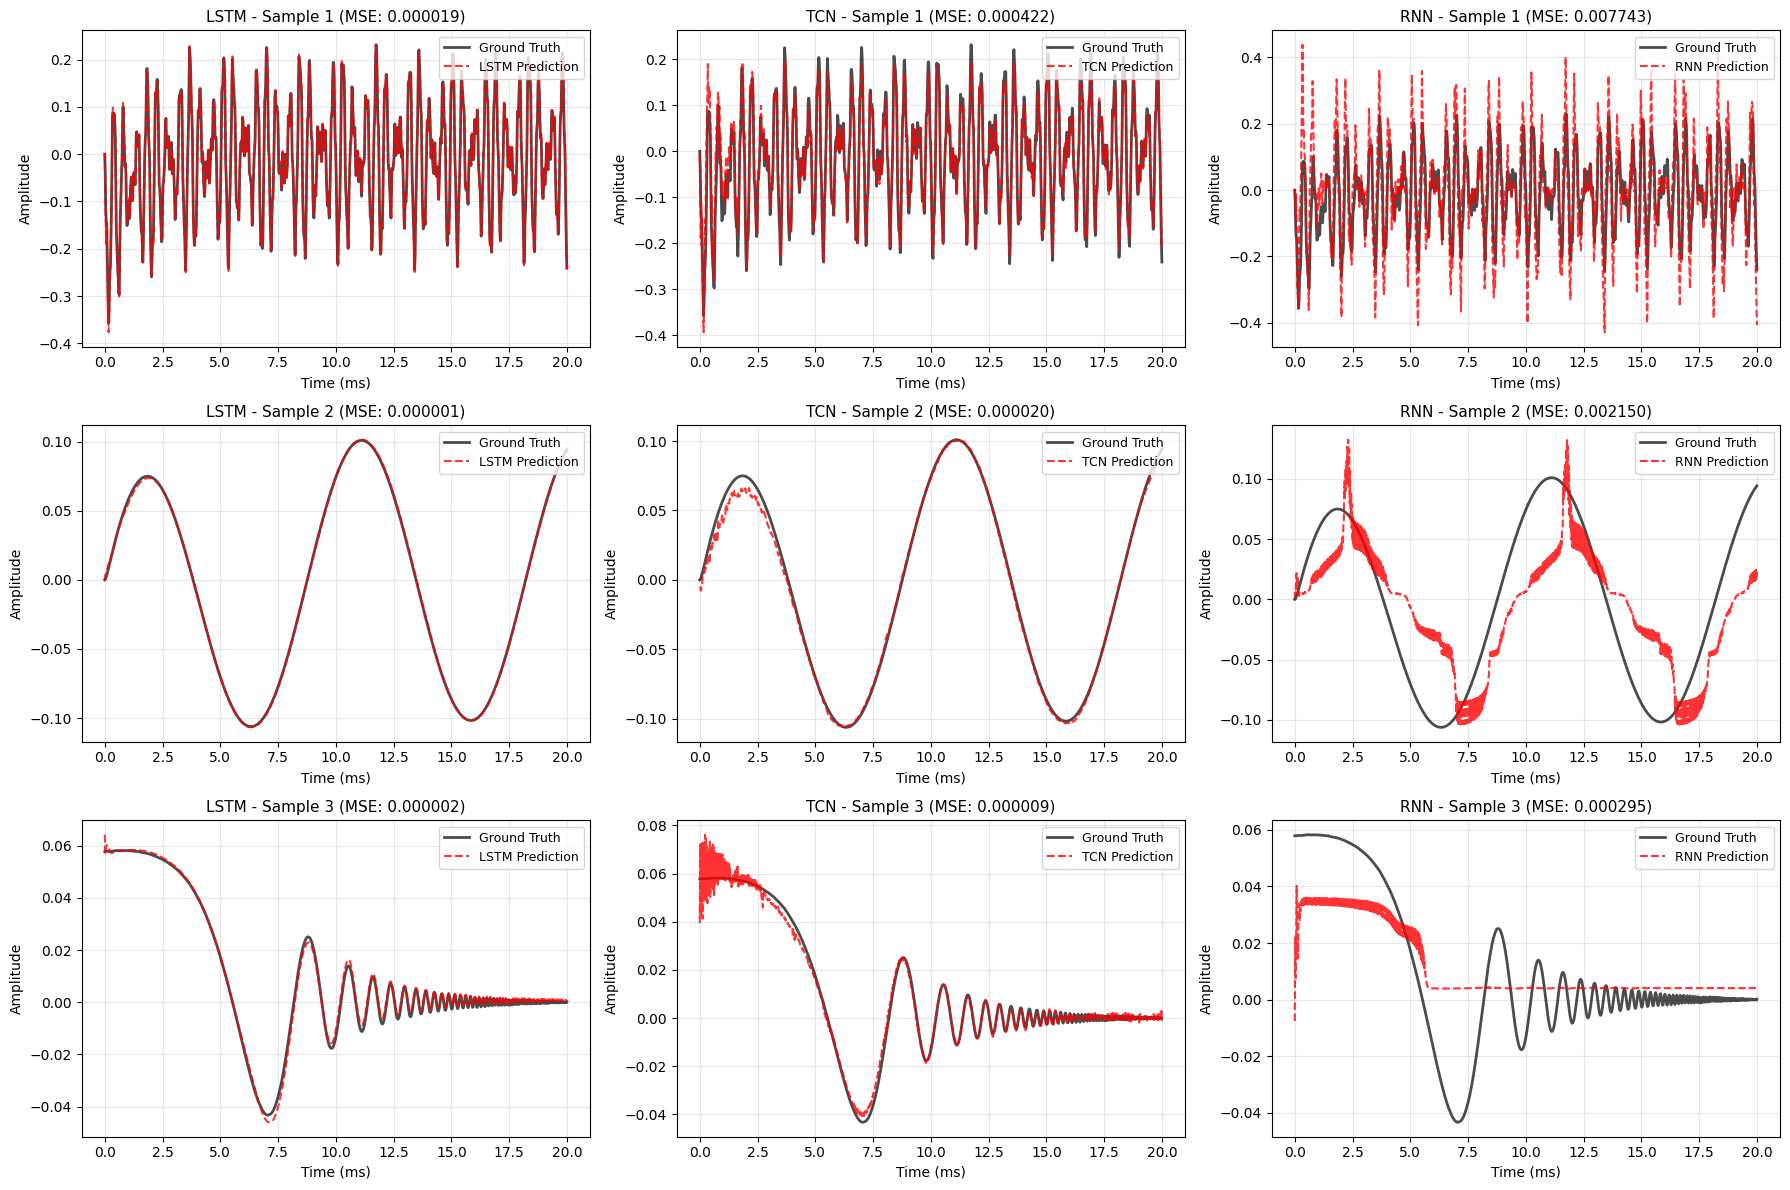

✓ Comparación visual guardada en 'benchmark_visual_comparison.png'


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar algunas muestras aleatorias del test set para visualizar
num_samples = 3
np.random.seed(42)

# Obtener batch de test
test_iter = iter(test_loader)
x_batch, y_batch = next(test_iter)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

# Seleccionar índices aleatorios
sample_indices = np.random.choice(len(x_batch), num_samples, replace=False)

# Crear figura grande
fig, axes = plt.subplots(num_samples, 3, figsize=(18, 4*num_samples))
if num_samples == 1:
    axes = axes.reshape(1, -1)

print("Generando predicciones para verificación visual...\n")

for idx, sample_idx in enumerate(sample_indices):
    x_sample = x_batch[sample_idx:sample_idx+1]
    y_true = y_batch[sample_idx].cpu().numpy().flatten()

    # Tiempo en ms (asumiendo fs=48kHz, 960 samples = 20ms)
    time_ms = np.linspace(0, 20, len(y_true))

    # Predicciones de cada modelo
    for col, (name, model) in enumerate(models.items()):
        model.eval()
        with torch.no_grad():
            y_pred = model(x_sample).cpu().numpy().flatten()

        ax = axes[idx, col]

        # Plot
        ax.plot(time_ms, y_true, 'k-', label='Ground Truth', linewidth=2, alpha=0.7)
        ax.plot(time_ms, y_pred, 'r--', label=f'{name} Prediction', linewidth=1.5, alpha=0.8)

        # Calcular error puntual
        error = np.abs(y_true - y_pred)
        mse_sample = np.mean((y_true - y_pred)**2)

        ax.set_xlabel('Time (ms)', fontsize=10)
        ax.set_ylabel('Amplitude', fontsize=10)
        ax.set_title(f'{name} - Sample {idx+1} (MSE: {mse_sample:.6f})', fontsize=11)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('benchmark_visual_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comparación visual guardada en 'benchmark_visual_comparison.png'")


In [23]:
import torch
import matplotlib.pyplot as plt

# Tomar una muestra del test set
test_iter = iter(test_loader)
x_sample, y_true = next(test_iter)
x_sample = x_sample[0:1].to(device)  # Solo 1 muestra

print("VERIFICACIÓN DE RUIDO ANALÓGICO\n" + "="*60)

# Cargar modelo LSTM
model = AnalogLSTMModel(
    input_size=BENCHMARK_CONFIG['input_size'],
    hidden_size=128,
    output_size=1,
    num_layers=2,
    analog_levels=BENCHMARK_CONFIG['analog_levels'],
    noise_std=BENCHMARK_CONFIG['noise_std']
).to(device)

checkpoint = torch.load('lstm_anal_final.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Test 1: Modo entrenamiento (CON ruido)
print("\n1️⃣ Modo TRAINING (ruido activado):")
model.train()  # Activa ruido
predictions_with_noise = []
for i in range(10):
    with torch.no_grad():
        pred = model(x_sample).cpu().numpy().flatten()
        predictions_with_noise.append(pred)

# Calcular variabilidad
std_with_noise = np.std(predictions_with_noise, axis=0).mean()
print(f"   Desviación estándar promedio entre predicciones: {std_with_noise:.6f}")

# Test 2: Modo evaluación (SIN ruido)
print("\n2️⃣ Modo EVAL (ruido desactivado):")
model.eval()  # Desactiva ruido
predictions_no_noise = []
for i in range(10):
    with torch.no_grad():
        pred = model(x_sample).cpu().numpy().flatten()
        predictions_no_noise.append(pred)

std_no_noise = np.std(predictions_no_noise, axis=0).mean()
print(f"   Desviación estándar promedio entre predicciones: {std_no_noise:.6f}")

# Conclusión
print("\n" + "="*60)
if std_with_noise > std_no_noise * 10:  # Al menos 10x más variabilidad
    print("✅ RUIDO VERIFICADO: El modelo tiene variabilidad estocástica en training")
    print(f"   Ratio variabilidad: {std_with_noise/std_no_noise:.1f}x más en training")
else:
    print("⚠️  ADVERTENCIA: No se detecta variabilidad significativa")
print("="*60)


VERIFICACIÓN DE RUIDO ANALÓGICO

1️⃣ Modo TRAINING (ruido activado):


/tmp/ipython-input-355548101.py:55: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  out, _ = stateless.functional_call(self.lstm, noisy_params, (x, (h0, c0)))


   Desviación estándar promedio entre predicciones: 0.000809

2️⃣ Modo EVAL (ruido desactivado):
   Desviación estándar promedio entre predicciones: 0.000000

✅ RUIDO VERIFICADO: El modelo tiene variabilidad estocástica en training
   Ratio variabilidad: 2503772.8x más en training


Generando predicciones para visualización...



/tmp/ipython-input-355548101.py:55: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  out, _ = stateless.functional_call(self.lstm, noisy_params, (x, (h0, c0)))


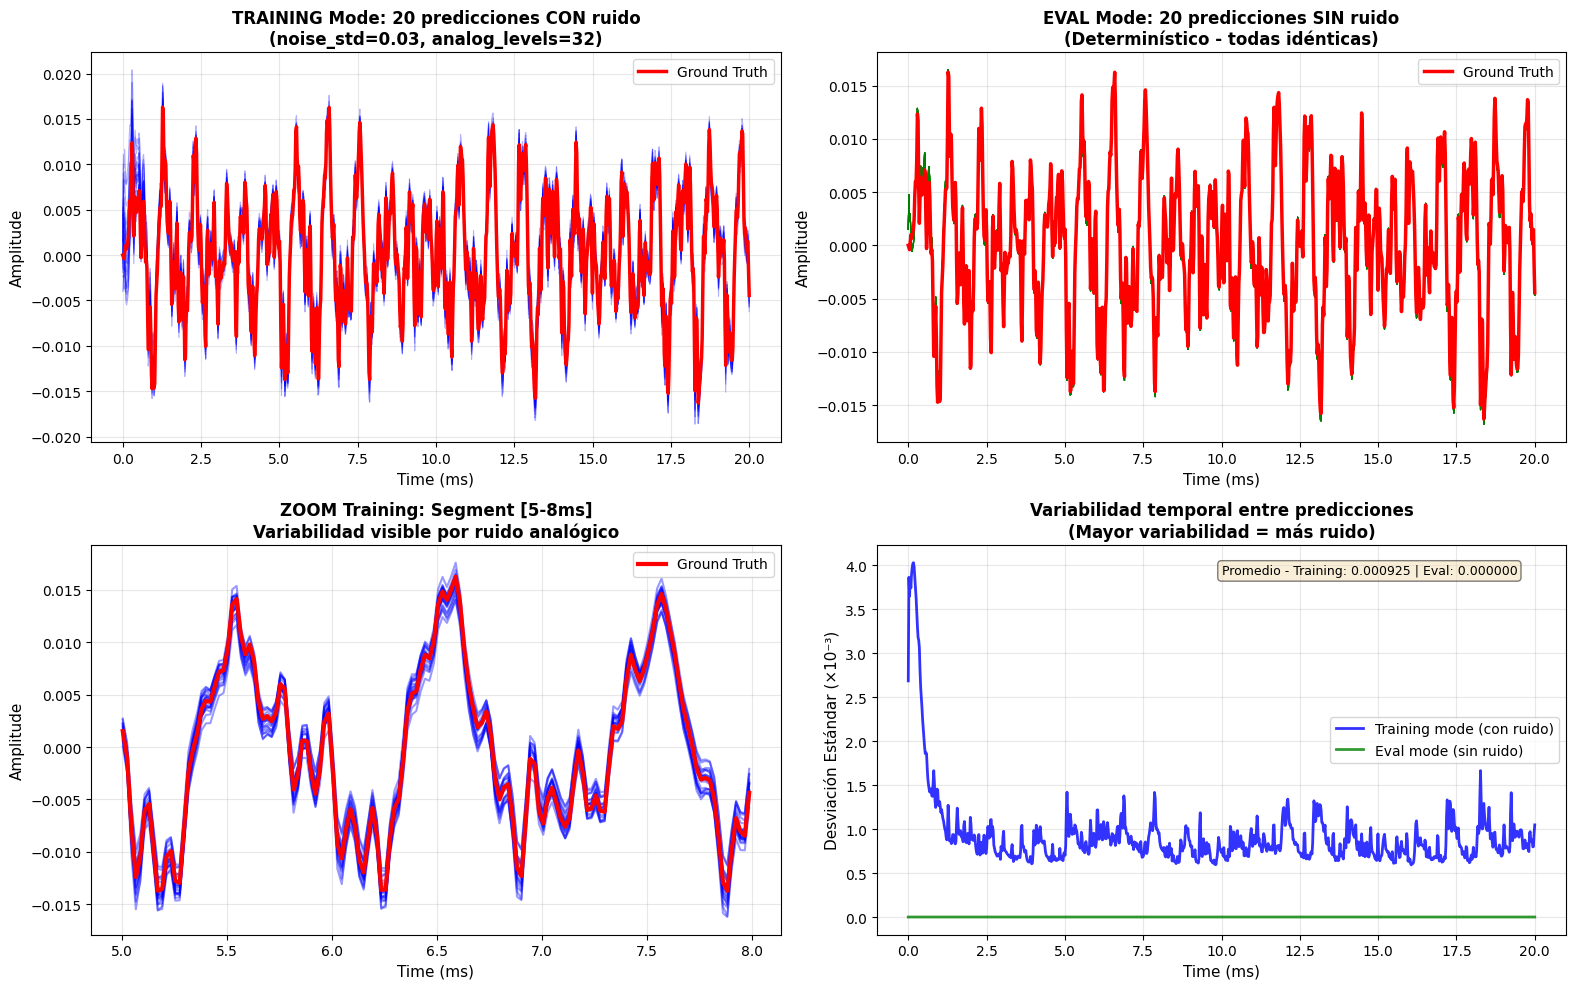

✅ Verificación visual guardada en 'verificacion_visual_ruido.png'

Estadísticas:
  Training mode - Desviación estándar promedio: 0.000925
  Eval mode     - Desviación estándar promedio: 0.000000
  Diferencia: 1551084.1x más variabilidad en training


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Tomar una muestra del test set
test_iter = iter(test_loader)
x_sample, y_true = next(test_iter)
x_sample = x_sample[0:1].to(device)  # Solo 1 muestra
y_true_np = y_true[0].cpu().numpy().flatten()

# Cargar modelo LSTM
model = AnalogLSTMModel(
    input_size=BENCHMARK_CONFIG['input_size'],
    hidden_size=128,
    output_size=1,
    num_layers=2,
    analog_levels=BENCHMARK_CONFIG['analog_levels'],
    noise_std=BENCHMARK_CONFIG['noise_std']
).to(device)

checkpoint = torch.load('lstm_anal_final.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Generar múltiples predicciones
num_runs = 20
time_ms = np.linspace(0, 20, len(y_true_np))  # 960 samples @ 48kHz = 20ms

print("Generando predicciones para visualización...\n")

# Modo TRAINING (con ruido)
model.train()
predictions_train = []
for i in range(num_runs):
    with torch.no_grad():
        pred = model(x_sample).cpu().numpy().flatten()
        predictions_train.append(pred)

# Modo EVAL (sin ruido)
model.eval()
predictions_eval = []
for i in range(num_runs):
    with torch.no_grad():
        pred = model(x_sample).cpu().numpy().flatten()
        predictions_eval.append(pred)

# Crear visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ========== SUBPLOT 1: Training mode - Todas las predicciones ==========
ax = axes[0, 0]
for i, pred in enumerate(predictions_train):
    ax.plot(time_ms, pred, 'b-', alpha=0.3, linewidth=0.8)
ax.plot(time_ms, y_true_np, 'r-', linewidth=2.5, label='Ground Truth', zorder=100)
ax.set_xlabel('Time (ms)', fontsize=11)
ax.set_ylabel('Amplitude', fontsize=11)
ax.set_title(f'TRAINING Mode: {num_runs} predicciones CON ruido\n(noise_std={BENCHMARK_CONFIG["noise_std"]}, analog_levels={BENCHMARK_CONFIG["analog_levels"]})',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# ========== SUBPLOT 2: Eval mode - Todas las predicciones ==========
ax = axes[0, 1]
for i, pred in enumerate(predictions_eval):
    ax.plot(time_ms, pred, 'g-', alpha=0.5, linewidth=0.8)
ax.plot(time_ms, y_true_np, 'r-', linewidth=2.5, label='Ground Truth', zorder=100)
ax.set_xlabel('Time (ms)', fontsize=11)
ax.set_ylabel('Amplitude', fontsize=11)
ax.set_title(f'EVAL Mode: {num_runs} predicciones SIN ruido\n(Determinístico - todas idénticas)',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# ========== SUBPLOT 3: Zoom de un segmento temporal ==========
zoom_start, zoom_end = 5, 8  # ms
zoom_idx_start = int(zoom_start * len(time_ms) / 20)
zoom_idx_end = int(zoom_end * len(time_ms) / 20)

ax = axes[1, 0]
for pred in predictions_train:
    ax.plot(time_ms[zoom_idx_start:zoom_idx_end], pred[zoom_idx_start:zoom_idx_end],
            'b-', alpha=0.4, linewidth=1.5)
ax.plot(time_ms[zoom_idx_start:zoom_idx_end], y_true_np[zoom_idx_start:zoom_idx_end],
        'r-', linewidth=3, label='Ground Truth', zorder=100)
ax.set_xlabel('Time (ms)', fontsize=11)
ax.set_ylabel('Amplitude', fontsize=11)
ax.set_title(f'ZOOM Training: Segment [{zoom_start}-{zoom_end}ms]\nVariabilidad visible por ruido analógico',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# ========== SUBPLOT 4: Desviación estándar por timestep ==========
std_train = np.std(predictions_train, axis=0)
std_eval = np.std(predictions_eval, axis=0)

ax = axes[1, 1]
ax.plot(time_ms, std_train * 1000, 'b-', linewidth=2, label='Training mode (con ruido)', alpha=0.8)
ax.plot(time_ms, std_eval * 1000, 'g-', linewidth=2, label='Eval mode (sin ruido)', alpha=0.8)
ax.set_xlabel('Time (ms)', fontsize=11)
ax.set_ylabel('Desviación Estándar (×10⁻³)', fontsize=11)
ax.set_title('Variabilidad temporal entre predicciones\n(Mayor variabilidad = más ruido)',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Estadísticas en el título
mean_std_train = np.mean(std_train)
mean_std_eval = np.mean(std_eval)
ax.text(0.5, 0.95, f'Promedio - Training: {mean_std_train:.6f} | Eval: {mean_std_eval:.6f}',
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('verificacion_visual_ruido.png', dpi=200, bbox_inches='tight')
plt.show()

print("✅ Verificación visual guardada en 'verificacion_visual_ruido.png'")
print(f"\nEstadísticas:")
print(f"  Training mode - Desviación estándar promedio: {mean_std_train:.6f}")
print(f"  Eval mode     - Desviación estándar promedio: {mean_std_eval:.6f}")
print(f"  Diferencia: {(mean_std_train/max(mean_std_eval, 1e-10)):.1f}x más variabilidad en training")


Generando predicciones con ruido para los 3 modelos...

Procesando LSTM...


/tmp/ipython-input-355548101.py:55: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  out, _ = stateless.functional_call(self.lstm, noisy_params, (x, (h0, c0)))


  ✓ Std Training: 0.001170
  ✓ Std Eval: 0.000000

Procesando TCN...
  ✓ Std Training: 0.003139
  ✓ Std Eval: 0.000000

Procesando RNN...


/tmp/ipython-input-3993368401.py:123: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  rnn_out, _ = stateless.functional_call(self.rnn, noisy_params, rnn_input)


  ✓ Std Training: 0.015487
  ✓ Std Eval: 0.000000



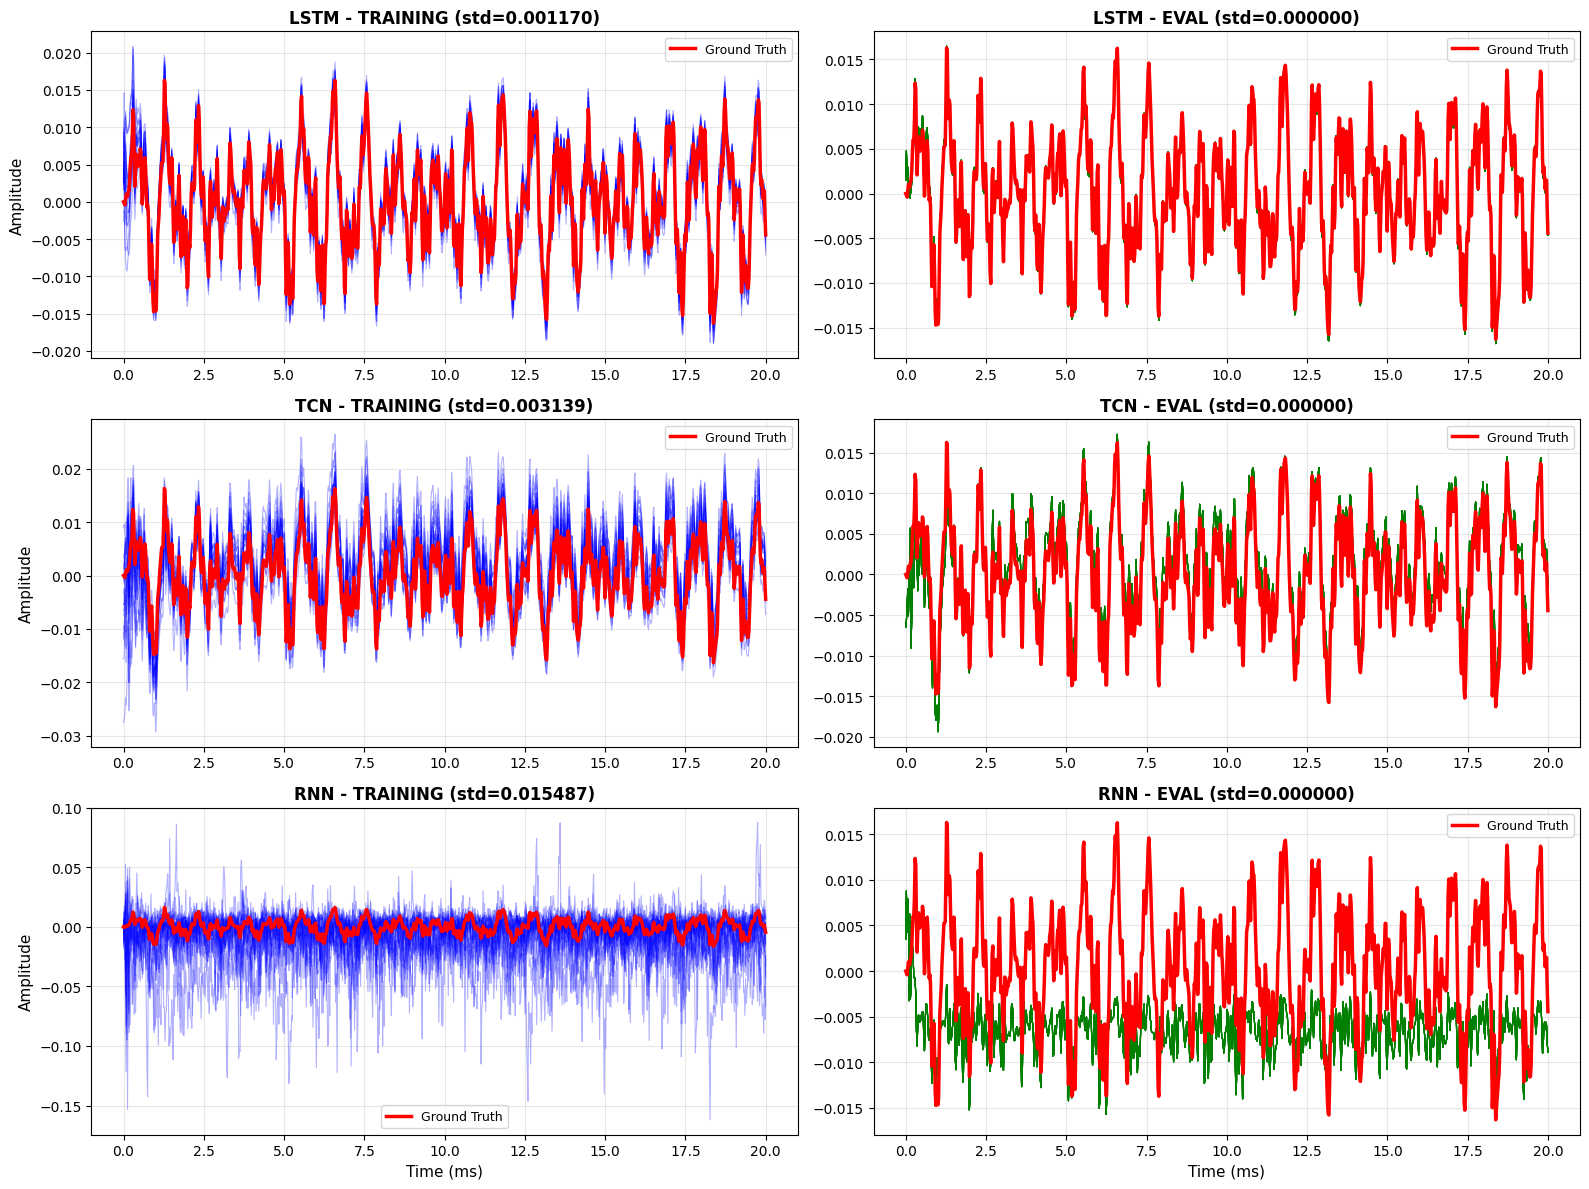


COMPARACIÓN DE ROBUSTEZ AL RUIDO
LSTM | Train std: 0.001170 | Eval std: 0.000000
TCN  | Train std: 0.003139 | Eval std: 0.000000
RNN  | Train std: 0.015487 | Eval std: 0.000000

✓ Visualización guardada en 'comparacion_ruido_3modelos.png'


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Tomar una muestra
test_iter = iter(test_loader)
x_sample, y_true = next(test_iter)
x_sample = x_sample[0:1].to(device)
y_true_np = y_true[0].cpu().numpy().flatten()
time_ms = np.linspace(0, 20, len(y_true_np))

num_runs = 20

# Diccionario para almacenar resultados
results_by_model = {}

print("Generando predicciones con ruido para los 3 modelos...\n")

for model_name in ['LSTM', 'TCN', 'RNN']:
    print(f"Procesando {model_name}...")

    # Cargar modelo correspondiente
    model = models[model_name]  # Ya los tienes cargados

    # Modo training (con ruido)
    model.train()
    preds_train = []
    for i in range(num_runs):
        with torch.no_grad():
            pred = model(x_sample).cpu().numpy().flatten()
            preds_train.append(pred)

    # Modo eval (sin ruido)
    model.eval()
    preds_eval = []
    for i in range(num_runs):
        with torch.no_grad():
            pred = model(x_sample).cpu().numpy().flatten()
            preds_eval.append(pred)

    results_by_model[model_name] = {
        'train': preds_train,
        'eval': preds_eval,
        'std_train': np.std(preds_train, axis=0).mean(),
        'std_eval': np.std(preds_eval, axis=0).mean()
    }

    print(f"  ✓ Std Training: {results_by_model[model_name]['std_train']:.6f}")
    print(f"  ✓ Std Eval: {results_by_model[model_name]['std_eval']:.6f}\n")

# Crear visualización comparativa
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for idx, model_name in enumerate(['LSTM', 'TCN', 'RNN']):
    data = results_by_model[model_name]

    # Columna izquierda: Training mode
    ax = axes[idx, 0]
    for pred in data['train']:
        ax.plot(time_ms, pred, 'b-', alpha=0.3, linewidth=0.8)
    ax.plot(time_ms, y_true_np, 'r-', linewidth=2.5, label='Ground Truth')
    ax.set_ylabel('Amplitude', fontsize=11)
    ax.set_title(f'{model_name} - TRAINING (std={data["std_train"]:.6f})',
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    if idx == 2:
        ax.set_xlabel('Time (ms)', fontsize=11)

    # Columna derecha: Eval mode
    ax = axes[idx, 1]
    for pred in data['eval']:
        ax.plot(time_ms, pred, 'g-', alpha=0.5, linewidth=0.8)
    ax.plot(time_ms, y_true_np, 'r-', linewidth=2.5, label='Ground Truth')
    ax.set_title(f'{model_name} - EVAL (std={data["std_eval"]:.6f})',
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    if idx == 2:
        ax.set_xlabel('Time (ms)', fontsize=11)

plt.tight_layout()
plt.savefig('comparacion_ruido_3modelos.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("COMPARACIÓN DE ROBUSTEZ AL RUIDO")
print("="*70)
for model_name in ['LSTM', 'TCN', 'RNN']:
    data = results_by_model[model_name]
    print(f"{model_name:4s} | Train std: {data['std_train']:.6f} | Eval std: {data['std_eval']:.6f}")
print("="*70)
print("\n✓ Visualización guardada en 'comparacion_ruido_3modelos.png'")
